Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action='ignore')

Read in the data and visualize it

In [5]:
sales = pd.read_csv("TOTALSA.csv", parse_dates=['DATE'])\
        .rename(columns = {'TOTALSA': 'Sales'})

GDP = pd.read_csv("GDP.csv", parse_dates=['DATE'])\
        .assign(GDP = lambda cols: cols['GDP']/1000)

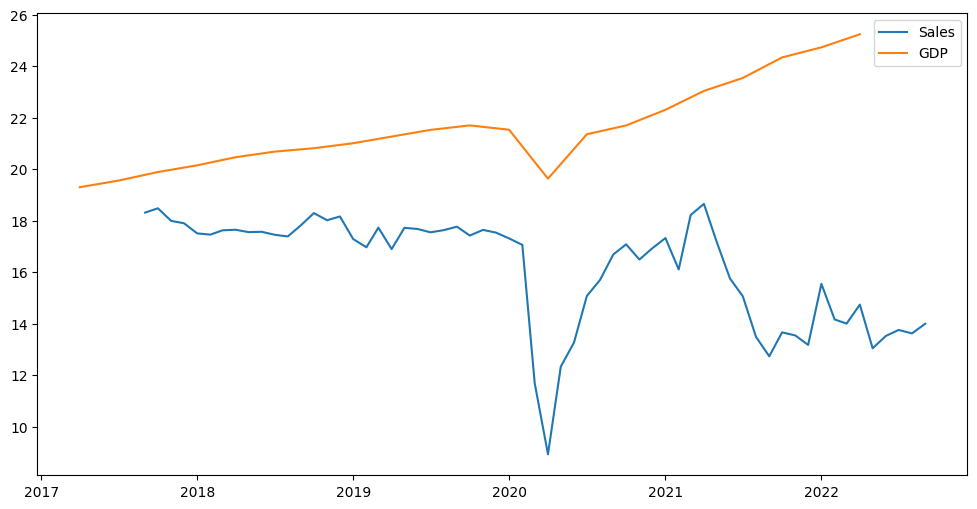

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sales['DATE'], sales['Sales'], label='Sales')
plt.plot(GDP['DATE'], GDP['GDP'], label='GDP')
plt.legend()
plt.show()

Get sales and GDP on the same time grain and impute missing values

In [7]:
GDP = GDP.assign(DATE = lambda cols: cols['DATE'] + pd.Timedelta(32, 'D'))\
    .assign(DATE = lambda cols: cols['DATE'].apply(lambda x: x.replace(day=1)))

GDP

,DATE,GDP
0,2017-05-01,19.304506
1,2017-08-01,19.561896
2,2017-11-01,19.894750
3,2018-02-01,20.155486
4,2018-05-01,20.470197
5,2018-08-01,20.687278
6,2018-11-01,20.819269
7,2019-02-01,21.013085
8,2019-05-01,21.272448
9,2019-08-01,21.531839


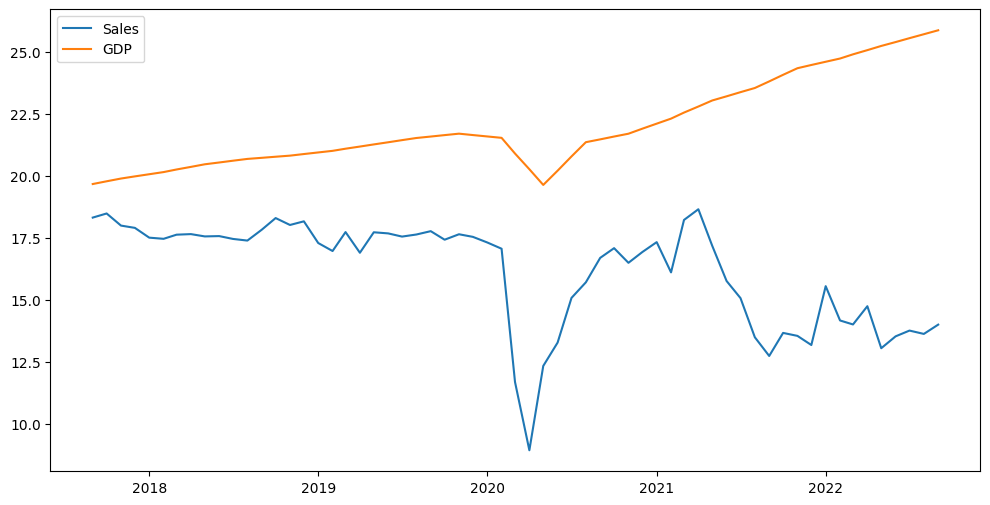

In [8]:
df = pd.merge(
    left = sales, 
    right = GDP, 
    on = 'DATE', 
    how = 'outer'
).sort_values(by = 'DATE', ascending=True)

df['GDP'] = df['GDP'].interpolate(method='linear', limit_direction='backward')

GDP_avg_growth_rate = (df['GDP'] / df['GDP'].shift(1)).dropna().tail(5).mean()
for i in range(df.shape[0]):
    if(pd.isnull(df.loc[i, 'GDP'])):
        df.loc[i, 'GDP'] = df.loc[i-1, 'GDP'] * GDP_avg_growth_rate

df = df.dropna(axis=0, how='any').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['Sales'], label='Sales')
plt.plot(df['DATE'], df['GDP'], label='GDP')
plt.legend()
plt.show()

Create training and test sets

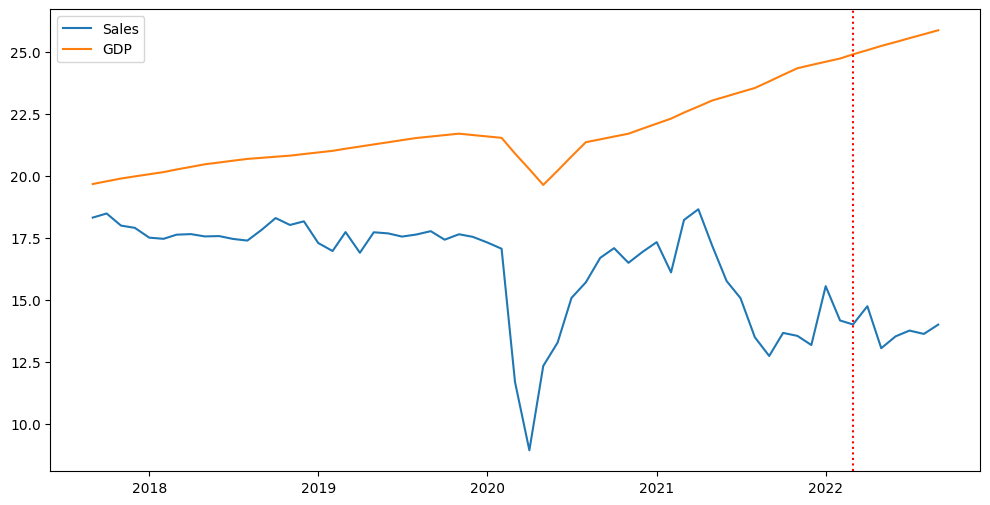

In [9]:
MAX_TRAINING_DATE = df.tail(7).iloc[0]['DATE']


plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['Sales'], label='Sales')
plt.plot(df['DATE'], df['GDP'], label='GDP')
plt.axvline(MAX_TRAINING_DATE, color='red', linestyle='dotted')
plt.legend()
plt.show()

df_train = df.loc[df['DATE'] < MAX_TRAINING_DATE, :]
df_test = df.loc[df['DATE'] >= MAX_TRAINING_DATE, :]


Build an initial model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52321D+00    |proj g|=  1.62088D-01

At iterate    5    f=  1.50524D+00    |proj g|=  9.85380D-03

At iterate   10    f=  1.50372D+00    |proj g|=  1.89604D-03

At iterate   15    f=  1.50321D+00    |proj g|=  1.68528D-02

At iterate   20    f=  1.50305D+00    |proj g|=  4.50532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   1.785D-05   1.503D+00
  F =   1.5030535339951763     

CONVERG

 This problem is unconstrained.


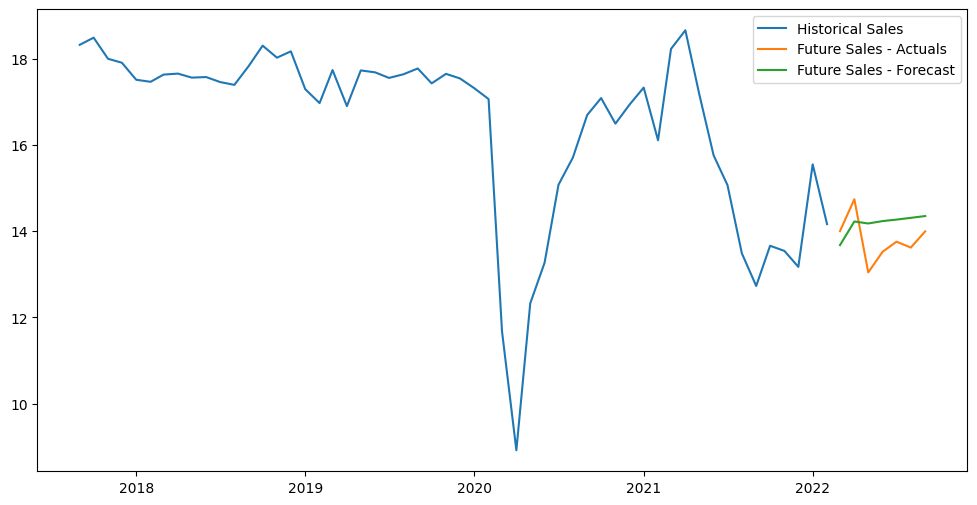

In [10]:
model = SARIMAX(
    endog = df_train['Sales'], 
    exog = df_train['GDP'], 
    order = (1, 1, 3), # p, d, q order parameters for arima
    trend = [1, 0], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (0,0,0, 12) # P, D, Q seasonal order parameters
).fit()

forecast = model.forecast(steps=df_test.shape[0], exog=df_test['GDP'])

plt.figure(figsize = (12, 6))
plt.plot(df_train['DATE'], df_train['Sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['Sales'], label='Future Sales - Actuals')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()


Create hyperparameter scoring function and parameter search step function

In [11]:
# Function to 'step' randomly in hyperparameter space
def step(params): 
    updated_params = deepcopy(params)
    selected_variable = np.random.choice(['p', 'd', 'q', 'P', 'D', 'Q', 'a0', 'a1'], size=1)[0]
    current_value = updated_params[selected_variable]

    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1, 1], size=1)[0]

    # Enforce parameter limits
    if(selected_variable in ['p', 'q']):
        low, high = 0, 6
    else:
        low, high = 0, 1
    
    updated_value = min([max([low, updated_value]), high])

    updated_params[selected_variable] = updated_value

    return updated_params

# Function to score hyperparameter set
def score(params, data):
    
    error_scores = []

    for validation_steps in [1,2,3,4,5]:
        training_set_length = data.shape[0] - validation_steps

        model = SARIMAX(
            endog = data['Sales'].head(training_set_length), 
            exog = data['GDP'].head(training_set_length), 
            order = (params['p'], params['d'], params['q']), # p, d, q order parameters for arima
            trend = [params['a0'], params['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
            seasonal_order = (params['P'], params['D'], params['Q'], 12) # P, D, Q seasonal order parameters
        ).fit()

        forecast = model.forecast(steps=validation_steps, exog=data['GDP'].tail(validation_steps))
        actuals = data['Sales'].tail(validation_steps)
        
        # compute error metric and return
        error = (forecast.tail(1) - actuals.tail(1)).abs().mean()
        error_scores.append(error)

    return np.mean(error_scores)



Run hyperparameter optimization scan

In [12]:
# Initial guess
x0 = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 1}
f0 = score(x0, df_train)

# Keep track of best parameters
xbest = deepcopy(x0)
fbest = f0

print('initial parameter score = ', f0)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53344D+00    |proj g|=  4.12889D-02

At iterate    5    f=  1.53341D+00    |proj g|=  1.20535D-01

At iterate   10    f=  1.53281D+00    |proj g|=  1.96011D-01

At iterate   15    f=  1.53026D+00    |proj g|=  3.07289D-01

At iterate   20    f=  1.53001D+00    |proj g|=  4.29954D-02

At iterate   25    f=  1.52983D+00    |proj g|=  2.52528D-01

At iterate   30    f=  1.52967D+00    |proj g|=  1.76437D-02

At iterate   35    f=  1.52967D+00    |proj g|=  1.93151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


In [13]:
optimization_steps = 100

temperature = 0.05

optimization_progress = {'f0': [], 'fbest': []}

for t in range(optimization_steps):

    # Randomly changed x0
    x1 = step(x0)
    f1 = score(x1, df_train)

    # If the new point is lower in score than the previous (meaning better)
    if(f1 < f0):
        x0 = deepcopy(x1)
        f0 = f1
    else: # if new point is worse, accept with some probability
        if(np.random.random() < 2**(-(f1-f0)/temperature)):
            x0 = deepcopy(x1)
            f0 = f1

    # Update the 'best' parameters
    if(f0 < fbest):
        fbest = f0
        xbest = deepcopy(x0)

    # Print out progress
    print('current score = {}, best score = {}'.format(f0, fbest))
    optimization_progress['f0'].append(f0)
    optimization_progress['fbest'].append(fbest)


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53000D+00    |proj g|=  1.17587D+00

At iterate    5    f=  1.52501D+00    |proj g|=  5.88782D-01

At iterate   10    f=  1.52038D+00    |proj g|=  3.03616D-01

At iterate   15    f=  1.51992D+00    |proj g|=  2.39943D-02

At iterate   20    f=  1.51911D+00    |proj g|=  3.36695D-01

At iterate   25    f=  1.51794D+00    |proj g|=  1.34184D-02

At iterate   30    f=  1.51793D+00    |proj g|=  3.04677D-02

At iterate   35    f=  1.51773D+00    |proj g|=  9.52168D-02

At iterate   40    f=  1.51768D+00    |proj g|=  1.00527D-03

At iterate   45    f=  1.51768D+00    |proj g|=  5.09046D-03

At iterate   50    f=  1.51767D+00    |proj g|=  4.50826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.50534D+00    |proj g|=  3.33752D-03

At iterate   40    f=  1.50532D+00    |proj g|=  9.05569D-03

At iterate   45    f=  1.50531D+00    |proj g|=  4.21287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     54      1     0     0   1.178D-03   1.505D+00
  F =   1.5053120106670506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47634D+00    |proj g|=  1.48907D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  1.47377D+00    |proj g|=  9.27769D-02

At iterate   15    f=  1.47280D+00    |proj g|=  9.54869D-02

At iterate   20    f=  1.47075D+00    |proj g|=  1.42143D-02

At iterate   25    f=  1.47069D+00    |proj g|=  6.34729D-02

At iterate   30    f=  1.47063D+00    |proj g|=  1.87819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     60      1     0     0   2.930D-05   1.471D+00
  F =   1.4706245726748932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.48162D+00    |proj g|=  1.30731D-01

At iterate   25    f=  1.48064D+00    |proj g|=  9.50157D-02

At iterate   30    f=  1.47967D+00    |proj g|=  5.06519D-03

At iterate   35    f=  1.47962D+00    |proj g|=  1.75003D-02

At iterate   40    f=  1.47962D+00    |proj g|=  9.70615D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     45      1     0     0   9.706D-06   1.480D+00
  F =   1.4796188475662253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.46259D+00    |proj g|=  3.28152D-02

At iterate   25    f=  1.46254D+00    |proj g|=  1.34258D-01

At iterate   30    f=  1.46249D+00    |proj g|=  3.37500D-02

At iterate   35    f=  1.46244D+00    |proj g|=  2.78236D-02

At iterate   40    f=  1.46238D+00    |proj g|=  9.03355D-03

At iterate   45    f=  1.46236D+00    |proj g|=  6.07916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     53      1     0     0   6.079D-04   1.462D+00
  F =   1.4623618162137559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.47167D+00    |proj g|=  5.52923D-03

At iterate   35    f=  1.47163D+00    |proj g|=  1.57732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   1.645D-03   1.472D+00
  F =   1.4716319050025048     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51323D+00    |proj g|=  2.39026D-01

At iterate    5    f=  1.48179D+00    |proj g|=  1.53088D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.48247D+00    |proj g|=  3.85402D-02

At iterate   15    f=  1.48201D+00    |proj g|=  4.21914D-01

At iterate   20    f=  1.48137D+00    |proj g|=  1.45868D-02

At iterate   25    f=  1.48122D+00    |proj g|=  5.17920D-02

At iterate   30    f=  1.48116D+00    |proj g|=  7.87141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     47      1     0     0   7.871D-04   1.481D+00
  F =   1.4811559290661371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 1.4571790433595422, best score = 1.4305329741485142
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   30    f=  1.46249D+00    |proj g|=  3.37500D-02

At iterate   35    f=  1.46244D+00    |proj g|=  2.78236D-02

At iterate   40    f=  1.46238D+00    |proj g|=  9.03355D-03

At iterate   45    f=  1.46236D+00    |proj g|=  6.07916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     53      1     0     0   6.079D-04   1.462D+00
  F =   1.4623618162137559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.47348D+00    |proj g|=  9.39695D-02

At iterate   25    f=  1.47246D+00    |proj g|=  6.53377D-01

At iterate   30    f=  1.47167D+00    |proj g|=  5.52923D-03

At iterate   35    f=  1.47163D+00    |proj g|=  1.57732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   1.645D-03   1.472D+00
  F =   1.4716319050025048     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     37      1     0     0   6.079D-05   1.480D+00
  F =   1.4804660944282650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51614D+00    |proj g|=  2.49733D-01

At iterate    5    f=  1.48276D+00    |proj g|=  2.90649D-01

At iterate   10    f=  1.48247D+00    |proj g|=  3.85402D-02

At iterate   15    f=  1.48201D+00    |proj g|=  4.21914D-01

At iterate   20    f=  1.48137D+00    |proj g|=  1.45868D-02


 This problem is unconstrained.



At iterate   20    f=  1.46387D+00    |proj g|=  3.82510D-01

At iterate   25    f=  1.46374D+00    |proj g|=  1.36399D-02

At iterate   30    f=  1.46321D+00    |proj g|=  1.84929D-01

At iterate   35    f=  1.46313D+00    |proj g|=  9.96232D-03

At iterate   40    f=  1.46255D+00    |proj g|=  9.85650D-02

At iterate   45    f=  1.46232D+00    |proj g|=  6.56403D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     70      1     0     0   3.180D-04   1.462D+00
  F =   1.4623223354538126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.47544D+00    |proj g|=  9.05507D-01

At iterate   10    f=  1.47480D+00    |proj g|=  5.57571D-02

At iterate   15    f=  1.47437D+00    |proj g|=  7.54687D-02

At iterate   20    f=  1.47219D+00    |proj g|=  2.04569D-02

At iterate   25    f=  1.47211D+00    |proj g|=  2.34586D-01

At iterate   30    f=  1.47200D+00    |proj g|=  3.75238D-02

At iterate   35    f=  1.47189D+00    |proj g|=  7.79294D-03

At iterate   40    f=  1.47184D+00    |proj g|=  8.47123D-03

At iterate   45    f=  1.47160D+00    |proj g|=  1.71212D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     66   

 This problem is unconstrained.



At iterate   35    f=  1.48145D+00    |proj g|=  8.39943D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     59      1     0     0   1.634D-03   1.481D+00
  F =   1.4814466346327664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49717D+00    |proj g|=  5.90154D-01

At iterate    5    f=  1.48433D+00    |proj g|=  1.31262D-01

At iterate   10    f=  1.48416D+00    |proj g|=  2.61322D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f=  1.48144D+00    |proj g|=  1.66583D-02

At iterate   40    f=  1.48141D+00    |proj g|=  4.28659D-02

At iterate   45    f=  1.48093D+00    |proj g|=  1.26507D-01

At iterate   50    f=  1.48085D+00    |proj g|=  4.29429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   4.294D-03   1.481D+00
  F =   1.4808526215495161     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 1.4571790433595422, best score = 1.4305329741485142
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     59      1     0     0   5.904D-02   1.780D+00
  F =   1.7803392091328512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84558D+00    |proj g|=  1.54880D+00

At iterate    5    f=  1.83974D+00    |proj g|=  1.00741D+00

At iterate   10    f=  1.80447D+00    |proj g|=  2.64732D-01

At iterate   15    f=  1.80428D+00    |proj g|=  2.85409D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  1.78830D+00    |proj g|=  3.79924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     70      1     0     0   3.799D-02   1.788D+00
  F =   1.7882965578265875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84111D+00    |proj g|=  1.58342D+00

At iterate    5    f=  1.83477D+00    |proj g|=  1.13827D+00

At iterate   10    f=  1.80412D+00    |proj g|=  2.51460D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52289D+00    |proj g|=  1.20637D+00

At iterate    5    f=  1.50935D+00    |proj g|=  6.76089D-01

At iterate   10    f=  1.50712D+00    |proj g|=  3.63058D-01

At iterate   15    f=  1.50703D+00    |proj g|=  3.25822D-02

At iterate   20    f=  1.50681D+00    |proj g|=  2.53428D-02

At iterate   25    f=  1.50622D+00    |proj g|=  3.83839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.46249D+00    |proj g|=  3.37500D-02

At iterate   35    f=  1.46244D+00    |proj g|=  2.78236D-02

At iterate   40    f=  1.46238D+00    |proj g|=  9.03355D-03

At iterate   45    f=  1.46236D+00    |proj g|=  6.07916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     53      1     0     0   6.079D-04   1.462D+00
  F =   1.4623618162137559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.48062D+00    |proj g|=  8.49703D-02

At iterate   20    f=  1.48047D+00    |proj g|=  2.37628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     37      1     0     0   6.079D-05   1.480D+00
  F =   1.4804660944282650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51614D+00    |proj g|=  2.49733D-01

At iterate    5    f=  1.48276D+00    |proj g|=  2.90649D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


current score = 1.4571790433595422, best score = 1.4305329741485142
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52405D+00    |proj g|=  1.30188D+00

At iterate    5    f=  1.50970D+00    |proj g|=  7.62782D-02

At iterate   10    f=  1.50829D+00    |proj g|=  6.87335D-01

At iterate   15    f=  1.50689D+00    |proj g|=  6.27589D-02

At iterate   20    f=  1.50671D+00    |proj g|=  2.06406D-01

At iterate   25    f=  1.50662D+00    |proj g|=  2.42515D-02

At iterate   30    f=  1.50598D+00    |proj g|=  5.43592D-01

At iterate   35    f=  1.50534D+00    |proj g|=  3.33752D-03

At iterate   40    f=  1.50532D+00    |proj g|=  9.05569D-03

At iterate   45    f=  1.50531D+00    |proj g|=  4.21287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored duri

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51320D+00    |proj g|=  2.31798D-01

At iterate    5    f=  1.49957D+00    |proj g|=  2.98271D+00

At iterate   10    f=  1.48302D+00    |proj g|=  1.40826D-01

At iterate   15    f=  1.48179D+00    |proj g|=  9.19949D-02

At iterate   20    f=  1.48162D+00    |proj g|=  1.30731D-01

At iterate   25    f=  1.48064D+00    |proj g|=  9.50157D-02

At iterate   30    f=  1.47967D+00    |proj g|=  5.06519D-03

At iterate   35    f=  1.47962D+00    |proj g|=  1.75003D-02

At iterate   40    f=  1.47962D+00    |proj g|=  9.70615D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


te    5    f=  1.50363D+00    |proj g|=  2.84656D+00

At iterate   10    f=  1.48347D+00    |proj g|=  2.49925D-01

At iterate   15    f=  1.48253D+00    |proj g|=  3.35390D-02

At iterate   20    f=  1.48240D+00    |proj g|=  2.22541D-01

At iterate   25    f=  1.48229D+00    |proj g|=  8.91606D-02

At iterate   30    f=  1.48193D+00    |proj g|=  2.38981D-01

At iterate   35    f=  1.48082D+00    |proj g|=  1.63295D-01

At iterate   40    f=  1.48073D+00    |proj g|=  6.85128D-03

At iterate   45    f=  1.48073D+00    |proj g|=  5.03238D-03
current score = 1.4305329741485142, best score = 1.4305329741485142

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  

 This problem is unconstrained.



At iterate   15    f=  1.46647D+00    |proj g|=  5.02637D-02

At iterate   20    f=  1.46342D+00    |proj g|=  3.34214D-01

At iterate   25    f=  1.46293D+00    |proj g|=  1.41540D-01

At iterate   30    f=  1.46248D+00    |proj g|=  6.31292D-02

At iterate   35    f=  1.46222D+00    |proj g|=  9.72131D-02

At iterate   40    f=  1.46164D+00    |proj g|=  6.20617D-02

At iterate   45    f=  1.46136D+00    |proj g|=  4.30080D-02

At iterate   50    f=  1.46125D+00    |proj g|=  2.80750D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.807D-02   1.461D+00
  F =   1.46124934198

 This problem is unconstrained.



At iterate   25    f=  1.47111D+00    |proj g|=  1.55917D-02

At iterate   30    f=  1.47106D+00    |proj g|=  6.45652D-03

At iterate   35    f=  1.47085D+00    |proj g|=  6.29410D-03

At iterate   40    f=  1.47060D+00    |proj g|=  1.18205D-01

At iterate   45    f=  1.47053D+00    |proj g|=  1.48336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     69      1     0     0   6.120D-04   1.471D+00
  F =   1.4705310154453175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  1.48010D+00    |proj g|=  5.94911D-02

At iterate   45    f=  1.48001D+00    |proj g|=  4.11386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     57      1     0     0   7.734D-06   1.480D+00
  F =   1.4800082329376594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49903D+00    |proj g|=  3.75428D-01

At iterate    5    f=  1.48448D+00    |proj g|=  2.78475D-01


 This problem is unconstrained.



At iterate   10    f=  1.48434D+00    |proj g|=  1.20565D-01

At iterate   15    f=  1.48384D+00    |proj g|=  2.49265D-01

At iterate   20    f=  1.48200D+00    |proj g|=  2.96655D-02

At iterate   25    f=  1.48148D+00    |proj g|=  3.78287D-03

At iterate   30    f=  1.48133D+00    |proj g|=  1.84573D-01

At iterate   35    f=  1.48123D+00    |proj g|=  2.29712D-02

At iterate   40    f=  1.48099D+00    |proj g|=  8.54993D-02

At iterate   45    f=  1.48058D+00    |proj g|=  7.07154D-02

At iterate   50    f=  1.48003D+00    |proj g|=  3.24832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

 This problem is unconstrained.


 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52297D+00    |proj g|=  4.01023D-01

At iterate    5    f=  1.50935D+00    |proj g|=  1.34650D+00

At iterate   10    f=  1.50800D+00    |proj g|=  4.34730D-02

At iterate   15    f=  1.50724D+00    |proj g|=  7.19737D-02

At iterate   20    f=  1.50644D+00    |proj g|=  3.00479D-02

At iterate   25    f=  1.50620D+00    |proj g|=  4.49836D-02

At iterate   30    f=  1.50593D+00    |proj g|=  1.03471D-01

At iterate   35    f=  1.50577D+00    |proj g|=  8.85284D-03

At iterate   40    f=  1.50574D+00    |proj g|=  2.37226D-02

At iterate   45    f=  1.50562D+00    |proj g|=  2.48500D-02

At iterate   50    f=  1.50442D+00    |proj g|=  6.01078D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of activ

 This problem is unconstrained.



At iterate   25    f=  1.46293D+00    |proj g|=  1.41540D-01

At iterate   30    f=  1.46248D+00    |proj g|=  6.31292D-02

At iterate   35    f=  1.46222D+00    |proj g|=  9.72131D-02

At iterate   40    f=  1.46164D+00    |proj g|=  6.20617D-02

At iterate   45    f=  1.46136D+00    |proj g|=  4.30080D-02

At iterate   50    f=  1.46125D+00    |proj g|=  2.80750D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.807D-02   1.461D+00
  F =   1.4612493419807546     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.47111D+00    |proj g|=  1.55917D-02

At iterate   30    f=  1.47106D+00    |proj g|=  6.45652D-03

At iterate   35    f=  1.47085D+00    |proj g|=  6.29410D-03

At iterate   40    f=  1.47060D+00    |proj g|=  1.18205D-01

At iterate   45    f=  1.47053D+00    |proj g|=  1.48336D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     69      1     0     0   6.120D-04   1.471D+00
  F =   1.4705310154453175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78490D+00    |proj g|=  1.45150D+00

At iterate    5    f=  1.58166D+00    |proj g|=  1.19030D+01

At iterate   10    f=  1.50796D+00    |proj g|=  1.07439D+00

At iterate   15    f=  1.49931D+00    |proj g|=  4.05000D+00

At iter

 This problem is unconstrained.



At iterate   45    f=  1.48001D+00    |proj g|=  4.11386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     57      1     0     0   7.734D-06   1.480D+00
  F =   1.4800082329376594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49903D+00    |proj g|=  3.75428D-01

At iterate    5    f=  1.48448D+00    |proj g|=  2.78475D-01

At iterate   10    f=  1.48434D+00    |proj g|=  1.20565D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  1.50562D+00    |proj g|=  2.48500D-02

At iterate   50    f=  1.50442D+00    |proj g|=  6.01078D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   6.011D-02   1.504D+00
  F =   1.5044178756147215     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47590D+00    |proj g|=  8.22864D-01

At iterate    5    f=  1.46861D+00    |proj g|=  8.60054D-01

At iter

 This problem is unconstrained.



At iterate   35    f=  1.47085D+00    |proj g|=  6.29410D-03

At iterate   40    f=  1.47060D+00    |proj g|=  1.18205D-01

At iterate   45    f=  1.47053D+00    |proj g|=  1.48336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     69      1     0     0   6.120D-04   1.471D+00
  F =   1.4705310154453175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78490D+00    |proj g|=  1.45150D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.50796D+00    |proj g|=  1.07439D+00

At iterate   15    f=  1.49931D+00    |proj g|=  4.05000D+00

At iterate   20    f=  1.48540D+00    |proj g|=  5.38518D-01

At iterate   25    f=  1.48474D+00    |proj g|=  3.91814D-01

At iterate   30    f=  1.48261D+00    |proj g|=  9.38252D-02

At iterate   35    f=  1.48219D+00    |proj g|=  9.18808D-02

At iterate   40    f=  1.48010D+00    |proj g|=  5.94911D-02

At iterate   45    f=  1.48001D+00    |proj g|=  4.11386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     57      1     0     0   7.734D-06   1.480D+00
  F =   1.48000823293

 This problem is unconstrained.



At iterate   40    f=  1.48099D+00    |proj g|=  8.54993D-02

At iterate   45    f=  1.48058D+00    |proj g|=  7.07154D-02

At iterate   50    f=  1.48003D+00    |proj g|=  3.24832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.248D-02   1.480D+00
  F =   1.4800296256329535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 1.5229385397496746, best score = 1.4305329741485142
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   25    f=  1.50080D+00    |proj g|=  7.44759D-03

At iterate   30    f=  1.50074D+00    |proj g|=  1.47024D-02

At iterate   35    f=  1.50071D+00    |proj g|=  5.57431D-03

At iterate   40    f=  1.50067D+00    |proj g|=  3.64635D-03

At iterate   45    f=  1.50063D+00    |proj g|=  1.76074D-02

At iterate   50    f=  1.50062D+00    |proj g|=  3.22446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   3.224D-03   1.501D+00
  F =   1.5006231550390139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.45807D+00    |proj g|=  6.87233D-02

At iterate   30    f=  1.45792D+00    |proj g|=  1.91213D-02

At iterate   35    f=  1.45760D+00    |proj g|=  3.30156D-03

At iterate   40    f=  1.45759D+00    |proj g|=  4.11171D-03

At iterate   45    f=  1.45755D+00    |proj g|=  3.38983D-04

At iterate   50    f=  1.45755D+00    |proj g|=  2.87428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   2.874D-04   1.458D+00
  F =   1.4575467316184798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.46786D+00    |proj g|=  3.74923D-02

At iterate   20    f=  1.46713D+00    |proj g|=  2.20387D-02

At iterate   25    f=  1.46708D+00    |proj g|=  1.09743D-02

At iterate   30    f=  1.46702D+00    |proj g|=  2.09638D-02

At iterate   35    f=  1.46686D+00    |proj g|=  1.03092D-02

At iterate   40    f=  1.46683D+00    |proj g|=  4.76089D-03

At iterate   45    f=  1.46681D+00    |proj g|=  3.49010D-04

At iterate   50    f=  1.46681D+00    |proj g|=  4.30918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   4.309D-04   1.467D+00
  F =   1.46680872861

 This problem is unconstrained.



At iterate   20    f=  1.47749D+00    |proj g|=  9.23484D-03

At iterate   25    f=  1.47728D+00    |proj g|=  5.65401D-02

At iterate   30    f=  1.47720D+00    |proj g|=  2.03539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     39      1     0     0   3.685D-04   1.477D+00
  F =   1.4771994658634622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50468D+00    |proj g|=  1.53001D+00

At iter

 This problem is unconstrained.



At iterate   20    f=  1.47835D+00    |proj g|=  1.38492D-01

At iterate   25    f=  1.47770D+00    |proj g|=  2.66256D-03

At iterate   30    f=  1.47746D+00    |proj g|=  2.56597D-02

At iterate   35    f=  1.47738D+00    |proj g|=  1.25422D-02

At iterate   40    f=  1.47738D+00    |proj g|=  8.24622D-03

At iterate   45    f=  1.47737D+00    |proj g|=  1.27288D-03
current score = 1.5521720707301494, best score = 1.4305329741485142

At iterate   50    f=  1.47735D+00    |proj g|=  4.00068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   4.001D-04   1.477D+00
  F =   1.47734

 This problem is unconstrained.



At iterate   10    f=  1.50457D+00    |proj g|=  7.94186D-02

At iterate   15    f=  1.50442D+00    |proj g|=  1.76382D-02

At iterate   20    f=  1.50390D+00    |proj g|=  2.16915D-01

At iterate   25    f=  1.50310D+00    |proj g|=  8.44491D-03

At iterate   30    f=  1.50301D+00    |proj g|=  2.83975D-03

At iterate   35    f=  1.50290D+00    |proj g|=  8.26148D-03

At iterate   40    f=  1.50289D+00    |proj g|=  1.57601D-03

At iterate   45    f=  1.50289D+00    |proj g|=  7.33920D-03

At iterate   50    f=  1.50288D+00    |proj g|=  1.01096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.



At iterate   15    f=  1.46001D+00    |proj g|=  4.41117D-02

At iterate   20    f=  1.45831D+00    |proj g|=  1.71519D-01

At iterate   25    f=  1.45806D+00    |proj g|=  6.35096D-03

At iterate   30    f=  1.45774D+00    |proj g|=  6.19640D-03

At iterate   35    f=  1.45774D+00    |proj g|=  6.48613D-03

At iterate   40    f=  1.45774D+00    |proj g|=  5.69346D-03

At iterate   45    f=  1.45773D+00    |proj g|=  7.85983D-04

At iterate   50    f=  1.45773D+00    |proj g|=  4.87646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   4.876D-03   1.458D+00
  F =   1.45773220541

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     55      1     0     0   3.069D-04   1.467D+00
  F =   1.4669897761093680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79279D+00    |proj g|=  1.84251D+00

At iterate    5    f=  1.60323D+00    |proj g|=  8.26670D+00

At iterate   10    f=  1.50485D+00    |proj g|=  1.33989D-01

At iterate   15    f=  1.47858D+00    |proj g|=  4.99184D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.47737D+00    |proj g|=  4.89387D-03

At iterate   35    f=  1.47737D+00    |proj g|=  1.01170D-03

At iterate   40    f=  1.47736D+00    |proj g|=  1.57560D-02

At iterate   45    f=  1.47734D+00    |proj g|=  2.35151D-03

At iterate   50    f=  1.47734D+00    |proj g|=  1.14018D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.140D-04   1.477D+00
  F =   1.4773411623750139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 1.5521720707301494, best score = 1.4305329741485142
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   20    f=  1.50644D+00    |proj g|=  3.00479D-02

At iterate   25    f=  1.50620D+00    |proj g|=  4.49836D-02

At iterate   30    f=  1.50593D+00    |proj g|=  1.03471D-01

At iterate   35    f=  1.50577D+00    |proj g|=  8.85284D-03

At iterate   40    f=  1.50574D+00    |proj g|=  2.37226D-02

At iterate   45    f=  1.50562D+00    |proj g|=  2.48500D-02

At iterate   50    f=  1.50442D+00    |proj g|=  6.01078D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   6.011D-02   1.504D+00
  F =   1.5044178756147215     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.46342D+00    |proj g|=  3.34214D-01

At iterate   25    f=  1.46293D+00    |proj g|=  1.41540D-01

At iterate   30    f=  1.46248D+00    |proj g|=  6.31292D-02

At iterate   35    f=  1.46222D+00    |proj g|=  9.72131D-02

At iterate   40    f=  1.46164D+00    |proj g|=  6.20617D-02

At iterate   45    f=  1.46136D+00    |proj g|=  4.30080D-02

At iterate   50    f=  1.46125D+00    |proj g|=  2.80750D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.807D-02   1.461D+00
  F =   1.4612493419807546     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


At iterate   25    f=  1.47111D+00    |proj g|=  1.55917D-02

At iterate   30    f=  1.47106D+00    |proj g|=  6.45652D-03

At iterate   35    f=  1.47085D+00    |proj g|=  6.29410D-03

At iterate   40    f=  1.47060D+00    |proj g|=  1.18205D-01

At iterate   45    f=  1.47053D+00    |proj g|=  1.48336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     69      1     0     0   6.120D-04   1.471D+00
  F =   1.4705310154453175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78490D+00    |proj g|=  1.45150D+00

At iterate    5    f=  1.58166D+00    |proj g|=  1.19030D+01

At iterate   10    f=  1.50796D+00    |proj g|=  1.07439D+00

At iterate   15    f=  1.49931D+00    |proj g|=  4.05000D+00

At iterate   20    f=  1.48540D+00    |proj g|=  5.38518D-01

At iterate   25    f=  1.48474D+00    |proj g|=  3.91814D-01

At iterate   30    f=  1.48261D+00    |proj g|=  9.38252D-02

At iterate   35    f=  1.48219D+00    |proj g|=  9.18808D-02

At iterate   40    f=  1.48010D+00    |proj g|=  5.94911D-02


 This problem is unconstrained.



At iterate   45    f=  1.48001D+00    |proj g|=  4.11386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     57      1     0     0   7.734D-06   1.480D+00
  F =   1.4800082329376594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49903D+00    |proj g|=  3.75428D-01

At iterate    5    f=  1.48448D+00    |proj g|=  2.78475D-01

At iterate   10    f=  1.48434D+00    |proj g|=  1.20565D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.50683D+00    |proj g|=  2.30693D-02

At iterate   30    f=  1.50647D+00    |proj g|=  2.44306D-02

At iterate   35    f=  1.50644D+00    |proj g|=  9.11191D-02

At iterate   40    f=  1.50626D+00    |proj g|=  9.28592D-03

At iterate   45    f=  1.50624D+00    |proj g|=  2.72916D-04

At iterate   50    f=  1.50624D+00    |proj g|=  5.30423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   5.304D-05   1.506D+00
  F =   1.5062433091559231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.46328D+00    |proj g|=  4.77114D-02

At iterate   30    f=  1.46249D+00    |proj g|=  7.72460D-03

At iterate   35    f=  1.46249D+00    |proj g|=  8.14543D-03

At iterate   40    f=  1.46248D+00    |proj g|=  1.43745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   1.130D-03   1.462D+00
  F =   1.4624840460183739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   30    f=  1.47172D+00    |proj g|=  1.12795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     51      1     0     0   1.909D-03   1.472D+00
  F =   1.4717159613217252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48753D+00    |proj g|=  2.66454D-01

At iterate    5    f=  1.48572D+00    |proj g|=  9.85678D-01

At iterate   10    f=  1.48294D+00    |proj g|=  2.44941D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.48258D+00    |proj g|=  1.46780D-01

At iterate   20    f=  1.48224D+00    |proj g|=  2.20664D-01

At iterate   25    f=  1.48071D+00    |proj g|=  8.77431D-02

At iterate   30    f=  1.48059D+00    |proj g|=  4.11633D-02

At iterate   35    f=  1.48059D+00    |proj g|=  2.30196D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     40      1     0     0   2.302D-05   1.481D+00
  F =   1.4805859874498133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.48355D+00    |proj g|=  1.29258D-01

At iterate   20    f=  1.48309D+00    |proj g|=  1.22489D-01
current score = 1.3776555592391528, best score = 1.3776555592391528

At iterate   25    f=  1.48192D+00    |proj g|=  2.02561D-01

At iterate   30    f=  1.48186D+00    |proj g|=  7.69870D-03

At iterate   35    f=  1.48185D+00    |proj g|=  1.33404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   3.943D-03   1.482D+00
  F =   1.4818518619610328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.46249D+00    |proj g|=  7.72460D-03

At iterate   35    f=  1.46249D+00    |proj g|=  8.14543D-03

At iterate   40    f=  1.46248D+00    |proj g|=  1.43745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   1.130D-03   1.462D+00
  F =   1.4624840460183739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47882D+00    |proj g|=  4.03498D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48753D+00    |proj g|=  2.66454D-01

At iterate    5    f=  1.48572D+00    |proj g|=  9.85678D-01

At iterate   10    f=  1.48294D+00    |proj g|=  2.44941D-02

At iterate   15    f=  1.48258D+00    |proj g|=  1.46780D-01

At iterate   20    f=  1.48224D+00    |proj g|=  2.20664D-01

At iterate   25    f=  1.48071D+00    |proj g|=  8.77431D-02

At iterate   30    f=  1.48059D+00    |proj g|=  4.11633D-02

At iterate   35    f=  1.48059D+00    |proj g|=  2.30196D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   20    f=  1.48309D+00    |proj g|=  1.22489D-01

At iterate   25    f=  1.48192D+00    |proj g|=  2.02561D-01

At iterate   30    f=  1.48186D+00    |proj g|=  7.69870D-03

At iterate   35    f=  1.48185D+00    |proj g|=  1.33404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   3.943D-03   1.482D+00
  F =   1.4818518619610328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 1.3776555592391528, best score = 1.3776555592391528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =       

 This problem is unconstrained.



At iterate    5    f=  1.51072D+00    |proj g|=  8.08688D-01

At iterate   10    f=  1.50813D+00    |proj g|=  1.54093D-02

At iterate   15    f=  1.50785D+00    |proj g|=  1.26076D-01

At iterate   20    f=  1.50768D+00    |proj g|=  1.35349D-01

At iterate   25    f=  1.50683D+00    |proj g|=  2.30693D-02

At iterate   30    f=  1.50647D+00    |proj g|=  2.44306D-02

At iterate   35    f=  1.50644D+00    |proj g|=  9.11191D-02

At iterate   40    f=  1.50626D+00    |proj g|=  9.28592D-03

At iterate   45    f=  1.50624D+00    |proj g|=  2.72916D-04

At iterate   50    f=  1.50624D+00    |proj g|=  5.30423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.46527D+00    |proj g|=  7.13551D-02

At iterate   20    f=  1.46453D+00    |proj g|=  4.13532D-01

At iterate   25    f=  1.46328D+00    |proj g|=  4.77114D-02

At iterate   30    f=  1.46249D+00    |proj g|=  7.72460D-03

At iterate   35    f=  1.46249D+00    |proj g|=  8.14543D-03

At iterate   40    f=  1.46248D+00    |proj g|=  1.43745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   1.130D-03   1.462D+00
  F =   1.4624840460183739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  1.47427D+00    |proj g|=  2.57661D-01

At iterate   20    f=  1.47322D+00    |proj g|=  2.30411D-01

At iterate   25    f=  1.47204D+00    |proj g|=  1.16058D-01

At iterate   30    f=  1.47172D+00    |proj g|=  1.12795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     51      1     0     0   1.909D-03   1.472D+00
  F =   1.4717159613217252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.48059D+00    |proj g|=  2.30196D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     40      1     0     0   2.302D-05   1.481D+00
  F =   1.4805859874498133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48881D+00    |proj g|=  2.52127D-01

At iterate    5    f=  1.48790D+00    |proj g|=  6.89371D-01

At iterate   10    f=  1.48377D+00    |proj g|=  2.14280D-02

At iter

 This problem is unconstrained.



At iterate   35    f=  1.50644D+00    |proj g|=  9.11191D-02

At iterate   40    f=  1.50626D+00    |proj g|=  9.28592D-03

At iterate   45    f=  1.50624D+00    |proj g|=  2.72916D-04

At iterate   50    f=  1.50624D+00    |proj g|=  5.30423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   5.304D-05   1.506D+00
  F =   1.5062433091559231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46641D+00    |proj g|=  9.24916D-01

At iterate   10    f=  1.46555D+00    |proj g|=  1.93713D-01

At iterate   15    f=  1.46527D+00    |proj g|=  7.13551D-02

At iterate   20    f=  1.46453D+00    |proj g|=  4.13532D-01

At iterate   25    f=  1.46328D+00    |proj g|=  4.77114D-02

At iterate   30    f=  1.46249D+00    |proj g|=  7.72460D-03

At iterate   35    f=  1.46249D+00    |proj g|=  8.14543D-03

At iterate   40    f=  1.46248D+00    |proj g|=  1.43745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   1.130D-03   1.462D+00
  F =   1.46248404601


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.48355D+00    |proj g|=  1.29258D-01

At iterate   20    f=  1.48309D+00    |proj g|=  1.22489D-01

At iterate   25    f=  1.48192D+00    |proj g|=  2.02561D-01

At iterate   30    f=  1.48186D+00    |proj g|=  7.69870D-03

At iterate   35    f=  1.48185D+00    |proj g|=  1.33404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   3.943D-03   1.482D+00
  F =   1.4818518619610328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 1.3776555592391528, best score = 1.3776555592391528
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   15    f=  1.50724D+00    |proj g|=  7.19737D-02

At iterate   20    f=  1.50644D+00    |proj g|=  3.00479D-02

At iterate   25    f=  1.50620D+00    |proj g|=  4.49836D-02

At iterate   30    f=  1.50593D+00    |proj g|=  1.03471D-01

At iterate   35    f=  1.50577D+00    |proj g|=  8.85284D-03

At iterate   40    f=  1.50574D+00    |proj g|=  2.37226D-02

At iterate   45    f=  1.50562D+00    |proj g|=  2.48500D-02

At iterate   50    f=  1.50442D+00    |proj g|=  6.01078D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   6.011D-02   1.504D+00
  F =   1.50441787561

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47590D+00    |proj g|=  8.22864D-01

At iterate    5    f=  1.46861D+00    |proj g|=  8.60054D-01

At iterate   10    f=  1.46791D+00    |proj g|=  5.70097D-02

At iterate   15    f=  1.46647D+00    |proj g|=  5.02637D-02

At iterate   20    f=  1.46342D+00    |proj g|=  3.34214D-01

At iterate   25    f=  1.46293D+00    |proj g|=  1.41540D-01

At iterate   30    f=  1.46248D+00    |proj g|=  6.31292D-02

At iterate   35    f=  1.46222D+00    |proj g|=  9.72131D-02

At iterate   40    f=  1.46164D+00    |proj g|=  6.20617D-02

At iterate   45    f=  1.46136D+00    |proj g|=  4.30080D-02

At iterate   50    f=  1.46125D+00    |proj g|=  2.80750D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


At iterate   25    f=  1.47111D+00    |proj g|=  1.55917D-02

At iterate   30    f=  1.47106D+00    |proj g|=  6.45652D-03

At iterate   35    f=  1.47085D+00    |proj g|=  6.29410D-03

At iterate   40    f=  1.47060D+00    |proj g|=  1.18205D-01

At iterate   45    f=  1.47053D+00    |proj g|=  1.48336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     69      1     0     0   6.120D-04   1.471D+00
  F =   1.4705310154453175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.58166D+00    |proj g|=  1.19030D+01

At iterate   10    f=  1.50796D+00    |proj g|=  1.07439D+00

At iterate   15    f=  1.49931D+00    |proj g|=  4.05000D+00

At iterate   20    f=  1.48540D+00    |proj g|=  5.38518D-01

At iterate   25    f=  1.48474D+00    |proj g|=  3.91814D-01

At iterate   30    f=  1.48261D+00    |proj g|=  9.38252D-02

At iterate   35    f=  1.48219D+00    |proj g|=  9.18808D-02

At iterate   40    f=  1.48010D+00    |proj g|=  5.94911D-02

At iterate   45    f=  1.48001D+00    |proj g|=  4.11386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     57   

 This problem is unconstrained.



At iterate   40    f=  1.48099D+00    |proj g|=  8.54993D-02

At iterate   45    f=  1.48058D+00    |proj g|=  7.07154D-02

At iterate   50    f=  1.48003D+00    |proj g|=  3.24832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.248D-02   1.480D+00
  F =   1.4800296256329535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 1.3776555592391528, best score = 1.3776555592391528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   25    f=  1.50261D+00    |proj g|=  1.62851D-01

At iterate   30    f=  1.50142D+00    |proj g|=  5.95995D-03

At iterate   35    f=  1.50125D+00    |proj g|=  7.07593D-02

At iterate   40    f=  1.50093D+00    |proj g|=  7.37174D-04

At iterate   45    f=  1.50093D+00    |proj g|=  1.74543D-03

At iterate   50    f=  1.50092D+00    |proj g|=  1.08992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   1.090D-03   1.501D+00
  F =   1.5009211806542946     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47317D+00    |proj g|=  1.74030D+00

At iterate    5    f=  1.46386D+00    |proj g|=  7.77998D-01

At iterate   10    f=  1.45939D+00    |proj g|=  1.07495D-01

At iterate   15    f=  1.45844D+00    |proj g|=  6.88994D-03

At iterate   20    f=  1.45838D+00    |proj g|=  1.07470D-02

At iterate   25    f=  1.45803D+00    |proj g|=  1.39059D-03

At iterate   30    f=  1.45802D+00    |proj g|=  6.76622D-04

At iterate   35    f=  1.45801D+00    |proj g|=  3.94255D-04

At iterate   40    f=  1.45801D+00    |proj g|=  2.05112D-03

At iterate   45    f=  1.45801D+00    |proj g|=  2.02109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   20    f=  1.46770D+00    |proj g|=  5.84727D-03

At iterate   25    f=  1.46741D+00    |proj g|=  8.00017D-02

At iterate   30    f=  1.46732D+00    |proj g|=  2.77884D-03

At iterate   35    f=  1.46728D+00    |proj g|=  1.22197D-03

At iterate   40    f=  1.46727D+00    |proj g|=  4.02260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     50      1     0     0   8.404D-04   1.467D+00
  F =   1.4672686846848417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49030D+00    |proj g|=  1.43353D+00

At iterate    5    f=  1.48216D+00    |proj g|=  8.11810D-01

At iterate   10    f=  1.47679D+00    |proj g|=  2.32047D-01

At iterate   15    f=  1.47626D+00    |proj g|=  2.41339D-02

At iterate   20    f=  1.47622D+00    |proj g|=  9.40213D-02

At iterate   25    f=  1.47602D+00    |proj g|=  3.80245D-02

At iterate   30    f=  1.47601D+00    |proj g|=  4.37516D-03

At iterate   35    f=  1.47601D+00    |proj g|=  1.39169D-02

At iterate   40    f=  1.47600D+00    |proj g|=  3.70845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   45    f=  1.50093D+00    |proj g|=  1.74543D-03

At iterate   50    f=  1.50092D+00    |proj g|=  1.08992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   1.090D-03   1.501D+00
  F =   1.5009211806542946     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47317D+00    |proj g|=  1.74030D+00

At iterate    5    f=  1.46386D+00    |proj g|=  7.77998D-01


 This problem is unconstrained.



At iterate   10    f=  1.45939D+00    |proj g|=  1.07495D-01

At iterate   15    f=  1.45844D+00    |proj g|=  6.88994D-03

At iterate   20    f=  1.45838D+00    |proj g|=  1.07470D-02

At iterate   25    f=  1.45803D+00    |proj g|=  1.39059D-03

At iterate   30    f=  1.45802D+00    |proj g|=  6.76622D-04

At iterate   35    f=  1.45801D+00    |proj g|=  3.94255D-04

At iterate   40    f=  1.45801D+00    |proj g|=  2.05112D-03

At iterate   45    f=  1.45801D+00    |proj g|=  2.02109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     55      1     0     0   2.021D-04   1.458D+00
  F =   1.45801240702

 This problem is unconstrained.



At iterate    5    f=  1.47292D+00    |proj g|=  7.58389D-01

At iterate   10    f=  1.46842D+00    |proj g|=  1.67212D-01

At iterate   15    f=  1.46779D+00    |proj g|=  3.89335D-02

At iterate   20    f=  1.46770D+00    |proj g|=  5.84727D-03

At iterate   25    f=  1.46741D+00    |proj g|=  8.00017D-02

At iterate   30    f=  1.46732D+00    |proj g|=  2.77884D-03

At iterate   35    f=  1.46728D+00    |proj g|=  1.22197D-03

At iterate   40    f=  1.46727D+00    |proj g|=  4.02260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     50      1     0     0   8.404D-04   1.467D+00
  F =   1.46726868468

 This problem is unconstrained.



At iterate   20    f=  1.47622D+00    |proj g|=  9.40213D-02

At iterate   25    f=  1.47602D+00    |proj g|=  3.80245D-02

At iterate   30    f=  1.47601D+00    |proj g|=  4.37516D-03

At iterate   35    f=  1.47601D+00    |proj g|=  1.39169D-02

At iterate   40    f=  1.47600D+00    |proj g|=  3.70845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     51      1     0     0   6.860D-04   1.476D+00
  F =   1.4760007907614332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.47862D+00    |proj g|=  7.20527D-02

At iterate   20    f=  1.47851D+00    |proj g|=  6.15901D-03

At iterate   25    f=  1.47846D+00    |proj g|=  5.66350D-02

At iterate   30    f=  1.47797D+00    |proj g|=  8.40803D-02

At iterate   35    f=  1.47790D+00    |proj g|=  3.38701D-02

At iterate   40    f=  1.47778D+00    |proj g|=  1.34073D-03

At iterate   45    f=  1.47778D+00    |proj g|=  6.59551D-04

At iterate   50    f=  1.47777D+00    |proj g|=  2.21357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.214D-03   1.478D+00
  F =   1.47776910794

 This problem is unconstrained.



At iterate   50    f=  1.50624D+00    |proj g|=  5.30423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   5.304D-05   1.506D+00
  F =   1.5062433091559231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46996D+00    |proj g|=  3.56029D-01

At iterate    5    f=  1.46641D+00    |proj g|=  9.24916D-01

At iterate   10    f=  1.46555D+00    |proj g|=  1.93713D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.46453D+00    |proj g|=  4.13532D-01

At iterate   25    f=  1.46328D+00    |proj g|=  4.77114D-02

At iterate   30    f=  1.46249D+00    |proj g|=  7.72460D-03

At iterate   35    f=  1.46249D+00    |proj g|=  8.14543D-03

At iterate   40    f=  1.46248D+00    |proj g|=  1.43745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   1.130D-03   1.462D+00
  F =   1.4624840460183739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.47204D+00    |proj g|=  1.16058D-01

At iterate   30    f=  1.47172D+00    |proj g|=  1.12795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     51      1     0     0   1.909D-03   1.472D+00
  F =   1.4717159613217252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48753D+00    |proj g|=  2.66454D-01

At iterate    5    f=  1.48572D+00    |proj g|=  9.85678D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.48377D+00    |proj g|=  2.14280D-02

At iterate   15    f=  1.48355D+00    |proj g|=  1.29258D-01

At iterate   20    f=  1.48309D+00    |proj g|=  1.22489D-01

At iterate   25    f=  1.48192D+00    |proj g|=  2.02561D-01

At iterate   30    f=  1.48186D+00    |proj g|=  7.69870D-03

At iterate   35    f=  1.48185D+00    |proj g|=  1.33404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   3.943D-03   1.482D+00
  F =   1.4818518619610328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 1.3776555592391528, best score = 1.

 This problem is unconstrained.



At iterate   20    f=  1.47356D+00    |proj g|=  1.44745D-02

At iterate   25    f=  1.47345D+00    |proj g|=  5.17066D-02

At iterate   30    f=  1.46678D+00    |proj g|=  1.10240D+00

At iterate   35    f=  1.46418D+00    |proj g|=  3.05395D-02

At iterate   40    f=  1.46394D+00    |proj g|=  1.28239D-01

At iterate   45    f=  1.46392D+00    |proj g|=  1.07442D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     92      2     0     0   2.098D-04   1.464D+00
  F =   1.4639212222047369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55566D+00    |proj g|=  4.64424D-01

At iterate    5    f=  1.45694D+00    |proj g|=  7.39731D-01

At iterate   10    f=  1.44998D+00    |proj g|=  2.92150D-01

At iterate   15    f=  1.44898D+00    |proj g|=  3.26905D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.44813D+00    |proj g|=  1.59056D-01

At iterate   45    f=  1.44806D+00    |proj g|=  4.65880D-02

At iterate   50    f=  1.44794D+00    |proj g|=  9.60460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   9.605D-03   1.448D+00
  F =   1.4479446465694756     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56547D+00    |proj g|=  4.57274D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58227D+00    |proj g|=  4.70679D-01

At iterate    5    f=  1.48441D+00    |proj g|=  8.31978D-01

At iterate   10    f=  1.47039D+00    |proj g|=  9.72094D-02

At iterate   15    f=  1.46960D+00    |proj g|=  1.42721D-02

At iterate   20    f=  1.46907D+00    |proj g|=  2.53619D-02

At iterate   25    f=  1.46895D+00    |proj g|=  4.35793D-03

At iterate   30    f=  1.46894D+00    |proj g|=  4.83359D-02

At iterate   35    f=  1.46848D+00    |proj g|=  4.34900D-01

At iterate   40    f=  1.46627D+00    |proj g|=  7.18077D-01

At iterate   45    f=  1.46215D+00    |proj g|=  6.77105D-02

At iterate   50    f=  1.46101D+00    |proj g|=  2.66319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   20    f=  1.44834D+00    |proj g|=  1.49378D-02

At iterate   25    f=  1.44833D+00    |proj g|=  8.76761D-03

At iterate   30    f=  1.44807D+00    |proj g|=  3.58727D-01

At iterate   35    f=  1.44481D+00    |proj g|=  5.60891D-01

At iterate   40    f=  1.44360D+00    |proj g|=  3.02892D-02

At iterate   45    f=  1.44333D+00    |proj g|=  6.39037D-02

At iterate   50    f=  1.44331D+00    |proj g|=  3.21226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.212D-04   1.443D+00
  F =   1.4433114942466361     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.45642D+00    |proj g|=  7.73457D-01

At iterate   15    f=  1.45514D+00    |proj g|=  1.85506D-01

At iterate   20    f=  1.45462D+00    |proj g|=  6.86226D-03

At iterate   25    f=  1.45458D+00    |proj g|=  7.13643D-02

At iterate   30    f=  1.45224D+00    |proj g|=  3.21772D-01

At iterate   35    f=  1.44958D+00    |proj g|=  3.71799D-01

At iterate   40    f=  1.44813D+00    |proj g|=  1.59056D-01

At iterate   45    f=  1.44806D+00    |proj g|=  4.65880D-02

At iterate   50    f=  1.44794D+00    |proj g|=  9.60460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58227D+00    |proj g|=  4.70679D-01

At iterate    5    f=  1.48441D+00    |proj g|=  8.31978D-01

At iterate   10    f=  1.47039D+00    |proj g|=  9.72094D-02

At iterate   15    f=  1.46960D+00    |proj g|=  1.42721D-02

At iterate   20    f=  1.46907D+00    |proj g|=  2.53619D-02

At iterate   25    f=  1.46895D+00    |proj g|=  4.35793D-03

At iterate   30    f=  1.46894D+00    |proj g|=  4.83359D-02

At iterate   35    f=  1.46848D+00    |proj g|=  4.34900D-01

At iterate   40    f=  1.46627D+00    |proj g|=  7.18077D-01

At iterate   45    f=  1.46215D+00    |proj g|=  6.77105D-02

At iterate   50    f=  1.46101D+00    |proj g|=  2.66319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   40    f=  1.46394D+00    |proj g|=  1.28239D-01

At iterate   45    f=  1.46392D+00    |proj g|=  1.07442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     92      2     0     0   2.098D-04   1.464D+00
  F =   1.4639212222047369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55566D+00    |proj g|=  4.64424D-01

At iterate    5    f=  1.45694D+00    |proj g|=  7.39731D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f=  1.44998D+00    |proj g|=  2.92150D-01

At iterate   15    f=  1.44898D+00    |proj g|=  3.26905D-01

At iterate   20    f=  1.44834D+00    |proj g|=  1.49378D-02

At iterate   25    f=  1.44833D+00    |proj g|=  8.76761D-03

At iterate   30    f=  1.44807D+00    |proj g|=  3.58727D-01

At iterate   35    f=  1.44481D+00    |proj g|=  5.60891D-01

At iterate   40    f=  1.44360D+00    |proj g|=  3.02892D-02

At iterate   45    f=  1.44333D+00    |proj g|=  6.39037D-02

At iterate   50    f=  1.44331D+00    |proj g|=  3.21226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61   

 This problem is unconstrained.



At iterate   30    f=  1.45224D+00    |proj g|=  3.21772D-01

At iterate   35    f=  1.44958D+00    |proj g|=  3.71799D-01

At iterate   40    f=  1.44813D+00    |proj g|=  1.59056D-01

At iterate   45    f=  1.44806D+00    |proj g|=  4.65880D-02

At iterate   50    f=  1.44794D+00    |proj g|=  9.60460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   9.605D-03   1.448D+00
  F =   1.4479446465694756     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   25    f=  1.45945D+00    |proj g|=  1.72627D-02

At iterate   30    f=  1.45944D+00    |proj g|=  1.55167D-02

At iterate   35    f=  1.45804D+00    |proj g|=  1.37945D-01

At iterate   40    f=  1.44954D+00    |proj g|=  2.16404D-01

At iterate   45    f=  1.44913D+00    |proj g|=  2.65810D-02

At iterate   50    f=  1.44912D+00    |proj g|=  8.86272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   8.863D-03   1.449D+00
  F =   1.4491179838820427     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   35    f=  1.46848D+00    |proj g|=  4.34900D-01

At iterate   40    f=  1.46627D+00    |proj g|=  7.18077D-01

At iterate   45    f=  1.46215D+00    |proj g|=  6.77105D-02

At iterate   50    f=  1.46101D+00    |proj g|=  2.66319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   2.663D-02   1.461D+00
  F =   1.4610114686622944     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 1.210710088916694, best score = 1.210710088916694
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.80741D+00    |proj g|=  3.42120D-01

At iterate   35    f=  1.80410D+00    |proj g|=  3.18674D-02

At iterate   40    f=  1.80353D+00    |proj g|=  2.36471D-01

At iterate   45    f=  1.80344D+00    |proj g|=  9.46021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     62      1     0     0   9.460D-05   1.803D+00
  F =   1.8034439641664808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   40    f=  1.81255D+00    |proj g|=  3.10649D-02

At iterate   45    f=  1.81252D+00    |proj g|=  1.37423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     72      2     0     0   1.374D-04   1.813D+00
  F =   1.8125248012328670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98117D+00    |proj g|=  2.79181D+00

At iterate    5    f=  1.88997D+00    |proj g|=  2.78906D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     85      2     0     0   7.635D-04   1.798D+00
  F =   1.7983684463702936     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95797D+00    |proj g|=  2.57399D+00

At iterate    5    f=  1.87284D+00    |proj g|=  2.84074D+00

At iterate   10    f=  1.81279D+00    |proj g|=  1.22776D-01

At iterate   15    f=  1.80320D+00    |proj g|=  7.60848D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47    113      3     0     0   2.116D-05   1.776D+00
  F =   1.7759346251128423     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94887D+00    |proj g|=  2.52316D+00

At iterate    5    f=  1.85986D+00    |proj g|=  2.97933D+00

At iterate   10    f=  1.80797D+00    |proj g|=  5.32519D-01

At iterate   15    f=  1.80338D+00    |proj g|=  5.40088D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.90959D+00    |proj g|=  1.44978D+00

At iterate   10    f=  1.82632D+00    |proj g|=  1.08240D+00

At iterate   15    f=  1.82162D+00    |proj g|=  1.31836D-01

At iterate   20    f=  1.80775D+00    |proj g|=  3.80848D-02

At iterate   25    f=  1.80774D+00    |proj g|=  3.89173D-03

At iterate   30    f=  1.80741D+00    |proj g|=  3.42120D-01

At iterate   35    f=  1.80410D+00    |proj g|=  3.18674D-02

At iterate   40    f=  1.80353D+00    |proj g|=  2.36471D-01

At iterate   45    f=  1.80344D+00    |proj g|=  9.46021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     62   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.81255D+00    |proj g|=  3.10649D-02

At iterate   45    f=  1.81252D+00    |proj g|=  1.37423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     72      2     0     0   1.374D-04   1.813D+00
  F =   1.8125248012328670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98117D+00    |proj g|=  2.79181D+00

At iterate    5    f=  1.88997D+00    |proj g|=  2.78906D+00


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.81824D+00    |proj g|=  1.99974D-01

At iterate   15    f=  1.81006D+00    |proj g|=  7.81452D-01

At iterate   20    f=  1.80840D+00    |proj g|=  1.91822D-03

At iterate   25    f=  1.80840D+00    |proj g|=  3.17619D-02

At iterate   30    f=  1.80782D+00    |proj g|=  3.55518D-01

At iterate   35    f=  1.79866D+00    |proj g|=  1.05048D-01

At iterate   40    f=  1.79837D+00    |proj g|=  1.04300D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     85      2     0     0   7.635D-04   1.798D+00
  F =   1.7983684463702936     

ABNORMAL_TERMINATION_IN_LNSRCH                    


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   20    f=  1.80071D+00    |proj g|=  3.04565D-03

At iterate   25    f=  1.80070D+00    |proj g|=  2.11679D-02

At iterate   30    f=  1.79913D+00    |proj g|=  3.91562D-01

At iterate   35    f=  1.77850D+00    |proj g|=  7.56917D-02

At iterate   40    f=  1.77596D+00    |proj g|=  3.07642D-02

At iterate   45    f=  1.77593D+00    |proj g|=  1.16255D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47    113      3     0     0   2.116D-05   1.776D+00
  F =   1.7759346251128423     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94887D+00    |proj g|=  2.52316D+00

At iterate    5    f=  1.85986D+00    |proj g|=  2.97933D+00

At iterate   10    f=  1.80797D+00    |proj g|=  5.32519D-01

At iterate   15    f=  1.80338D+00    |proj g|=  5.40088D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.47419D+00    |proj g|=  2.60583D-02

At iterate   15    f=  1.47396D+00    |proj g|=  2.53724D-01

At iterate   20    f=  1.47305D+00    |proj g|=  2.58220D-02

At iterate   25    f=  1.47255D+00    |proj g|=  5.52928D-03

At iterate   30    f=  1.47107D+00    |proj g|=  8.74516D-01

At iterate   35    f=  1.46852D+00    |proj g|=  5.06188D-01

At iterate   40    f=  1.46468D+00    |proj g|=  1.35338D+00

At iterate   45    f=  1.45968D+00    |proj g|=  4.51346D-01

At iterate   50    f=  1.45603D+00    |proj g|=  1.18449D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60   

 This problem is unconstrained.



At iterate   20    f=  1.44736D+00    |proj g|=  3.51592D-02

At iterate   25    f=  1.44687D+00    |proj g|=  2.26416D-01

At iterate   30    f=  1.44566D+00    |proj g|=  9.32498D-03

At iterate   35    f=  1.44565D+00    |proj g|=  6.05248D-03

At iterate   40    f=  1.44505D+00    |proj g|=  3.76922D-01

At iterate   45    f=  1.43926D+00    |proj g|=  8.41239D-01


 This problem is unconstrained.



At iterate   50    f=  1.43474D+00    |proj g|=  3.61491D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   3.615D-01   1.435D+00
  F =   1.4347382655970298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47164D+00    |proj g|=  1.65150D-01

At iterate    5    f=  1.45467D+00    |proj g|=  8.84490D-02

At iterate   10    f=  1.45393D+00    |proj g|=  4.40417D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.45312D+00    |proj g|=  4.35686D-01

At iterate   25    f=  1.44979D+00    |proj g|=  2.14855D-01

At iterate   30    f=  1.44931D+00    |proj g|=  1.55311D-02

At iterate   35    f=  1.44902D+00    |proj g|=  1.03961D-01

At iterate   40    f=  1.44682D+00    |proj g|=  2.56492D-01

At iterate   45    f=  1.44531D+00    |proj g|=  1.85873D-01

At iterate   50    f=  1.44187D+00    |proj g|=  1.61689D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.617D+00   1.442D+00
  F =   1.4418733996184334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.47650D+00    |proj g|=  8.00183D-01

At iterate   10    f=  1.47442D+00    |proj g|=  1.50732D+00

At iterate   15    f=  1.46846D+00    |proj g|=  4.00686D-02

At iterate   20    f=  1.46835D+00    |proj g|=  2.95958D-01

At iterate   25    f=  1.46726D+00    |proj g|=  2.32134D-01

At iterate   30    f=  1.46722D+00    |proj g|=  3.23676D-02

At iterate   35    f=  1.46548D+00    |proj g|=  6.52044D-01

At iterate   40    f=  1.46069D+00    |proj g|=  1.32659D-01

At iterate   45    f=  1.45884D+00    |proj g|=  5.02956D-01

At iterate   50    f=  1.45787D+00    |proj g|=  3.76503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f=  1.44372D+00    |proj g|=  3.86046D-02

At iterate   40    f=  1.44371D+00    |proj g|=  2.66474D-02

At iterate   45    f=  1.44216D+00    |proj g|=  3.24063D-01

At iterate   50    f=  1.44167D+00    |proj g|=  3.35376D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   3.354D-01   1.442D+00
  F =   1.4416675220331419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  1.42103D+00    |proj g|=  9.34596D-02

At iterate   20    f=  1.42036D+00    |proj g|=  4.46497D-01

At iterate   25    f=  1.42021D+00    |proj g|=  7.62945D-02

At iterate   30    f=  1.41990D+00    |proj g|=  1.11636D-01

At iterate   35    f=  1.41983D+00    |proj g|=  1.30055D-01

At iterate   40    f=  1.41963D+00    |proj g|=  9.23129D-02

At iterate   45    f=  1.41955D+00    |proj g|=  3.20816D-02

At iterate   50    f=  1.41855D+00    |proj g|=  7.17043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   7.170D-02   1.419D+00
  F =   1.41855319088

 This problem is unconstrained.



At iterate   25    f=  1.42509D+00    |proj g|=  2.89213D-02

At iterate   30    f=  1.42498D+00    |proj g|=  1.53048D-02

At iterate   35    f=  1.42494D+00    |proj g|=  1.75965D-02

At iterate   40    f=  1.42430D+00    |proj g|=  3.57397D-02

At iterate   45    f=  1.42392D+00    |proj g|=  4.67607D-02

At iterate   50    f=  1.42377D+00    |proj g|=  4.69360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   4.694D-02   1.424D+00
  F =   1.4237729077465937     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   35    f=  1.42312D+00    |proj g|=  7.78772D-03

At iterate   40    f=  1.42311D+00    |proj g|=  1.75122D-02

At iterate   45    f=  1.42308D+00    |proj g|=  1.63410D-02

At iterate   50    f=  1.42304D+00    |proj g|=  9.98590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   9.986D-03   1.423D+00
  F =   1.4230396943430181     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.43351D+00    |proj g|=  3.34377D-02

At iterate   15    f=  1.43330D+00    |proj g|=  6.01578D-03

At iterate   20    f=  1.43327D+00    |proj g|=  1.61217D-02

At iterate   25    f=  1.43326D+00    |proj g|=  1.37549D-02

At iterate   30    f=  1.43322D+00    |proj g|=  1.48664D-02

At iterate   35    f=  1.43302D+00    |proj g|=  2.44811D-01

At iterate   40    f=  1.43268D+00    |proj g|=  5.52523D-02

At iterate   45    f=  1.43266D+00    |proj g|=  1.17449D-02

At iterate   50    f=  1.43266D+00    |proj g|=  2.96955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.



At iterate   40    f=  1.46394D+00    |proj g|=  1.28239D-01

At iterate   45    f=  1.46392D+00    |proj g|=  1.07442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     92      2     0     0   2.098D-04   1.464D+00
  F =   1.4639212222047369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55566D+00    |proj g|=  4.64424D-01

At iterate    5    f=  1.45694D+00    |proj g|=  7.39731D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f=  1.44998D+00    |proj g|=  2.92150D-01

At iterate   15    f=  1.44898D+00    |proj g|=  3.26905D-01

At iterate   20    f=  1.44834D+00    |proj g|=  1.49378D-02

At iterate   25    f=  1.44833D+00    |proj g|=  8.76761D-03

At iterate   30    f=  1.44807D+00    |proj g|=  3.58727D-01

At iterate   35    f=  1.44481D+00    |proj g|=  5.60891D-01

At iterate   40    f=  1.44360D+00    |proj g|=  3.02892D-02

At iterate   45    f=  1.44333D+00    |proj g|=  6.39037D-02

At iterate   50    f=  1.44331D+00    |proj g|=  3.21226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.45224D+00    |proj g|=  3.21772D-01

At iterate   35    f=  1.44958D+00    |proj g|=  3.71799D-01

At iterate   40    f=  1.44813D+00    |proj g|=  1.59056D-01

At iterate   45    f=  1.44806D+00    |proj g|=  4.65880D-02

At iterate   50    f=  1.44794D+00    |proj g|=  9.60460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   9.605D-03   1.448D+00
  F =   1.4479446465694756     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   30    f=  1.46894D+00    |proj g|=  4.83359D-02

At iterate   35    f=  1.46848D+00    |proj g|=  4.34900D-01
current score = 0.922995705416669, best score = 0.922995705416669

At iterate   40    f=  1.46627D+00    |proj g|=  7.18077D-01

At iterate   45    f=  1.46215D+00    |proj g|=  6.77105D-02

At iterate   50    f=  1.46101D+00    |proj g|=  2.66319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   2.663D-02   1.461D+00
  F =   1.4610114686622944     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   20    f=  1.47356D+00    |proj g|=  1.44745D-02

At iterate   25    f=  1.47345D+00    |proj g|=  5.17066D-02

At iterate   30    f=  1.46678D+00    |proj g|=  1.10240D+00

At iterate   35    f=  1.46418D+00    |proj g|=  3.05395D-02

At iterate   40    f=  1.46394D+00    |proj g|=  1.28239D-01

At iterate   45    f=  1.46392D+00    |proj g|=  1.07442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     92      2     0     0   2.098D-04   1.464D+00
  F =   1.4639212222047369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.45694D+00    |proj g|=  7.39731D-01

At iterate   10    f=  1.44998D+00    |proj g|=  2.92150D-01

At iterate   15    f=  1.44898D+00    |proj g|=  3.26905D-01

At iterate   20    f=  1.44834D+00    |proj g|=  1.49378D-02

At iterate   25    f=  1.44833D+00    |proj g|=  8.76761D-03

At iterate   30    f=  1.44807D+00    |proj g|=  3.58727D-01

At iterate   35    f=  1.44481D+00    |proj g|=  5.60891D-01

At iterate   40    f=  1.44360D+00    |proj g|=  3.02892D-02

At iterate   45    f=  1.44333D+00    |proj g|=  6.39037D-02

At iterate   50    f=  1.44331D+00    |proj g|=  3.21226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.45458D+00    |proj g|=  7.13643D-02

At iterate   30    f=  1.45224D+00    |proj g|=  3.21772D-01

At iterate   35    f=  1.44958D+00    |proj g|=  3.71799D-01

At iterate   40    f=  1.44813D+00    |proj g|=  1.59056D-01

At iterate   45    f=  1.44806D+00    |proj g|=  4.65880D-02

At iterate   50    f=  1.44794D+00    |proj g|=  9.60460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   9.605D-03   1.448D+00
  F =   1.4479446465694756     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.47236D+00    |proj g|=  1.22780D+00

At iterate   10    f=  1.46402D+00    |proj g|=  1.48626D+00

At iterate   15    f=  1.46053D+00    |proj g|=  6.83250D-02

At iterate   20    f=  1.45966D+00    |proj g|=  2.22130D-02

At iterate   25    f=  1.45945D+00    |proj g|=  1.72627D-02

At iterate   30    f=  1.45944D+00    |proj g|=  1.55167D-02

At iterate   35    f=  1.45804D+00    |proj g|=  1.37945D-01

At iterate   40    f=  1.44954D+00    |proj g|=  2.16404D-01

At iterate   45    f=  1.44913D+00    |proj g|=  2.65810D-02

At iterate   50    f=  1.44912D+00    |proj g|=  8.86272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.48441D+00    |proj g|=  8.31978D-01

At iterate   10    f=  1.47039D+00    |proj g|=  9.72094D-02

At iterate   15    f=  1.46960D+00    |proj g|=  1.42721D-02

At iterate   20    f=  1.46907D+00    |proj g|=  2.53619D-02

At iterate   25    f=  1.46895D+00    |proj g|=  4.35793D-03

At iterate   30    f=  1.46894D+00    |proj g|=  4.83359D-02

At iterate   35    f=  1.46848D+00    |proj g|=  4.34900D-01

At iterate   40    f=  1.46627D+00    |proj g|=  7.18077D-01

At iterate   45    f=  1.46215D+00    |proj g|=  6.77105D-02

At iterate   50    f=  1.46101D+00    |proj g|=  2.66319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.44463D+00    |proj g|=  2.17307D-01

At iterate   20    f=  1.44388D+00    |proj g|=  1.47494D-02

At iterate   25    f=  1.44381D+00    |proj g|=  1.92812D-01

At iterate   30    f=  1.44377D+00    |proj g|=  2.03578D-02

At iterate   35    f=  1.44372D+00    |proj g|=  3.86046D-02

At iterate   40    f=  1.44371D+00    |proj g|=  2.66474D-02

At iterate   45    f=  1.44216D+00    |proj g|=  3.24063D-01

At iterate   50    f=  1.44167D+00    |proj g|=  3.35376D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   3.354D-01   1.442D+00
  F =   1.44166752203

 This problem is unconstrained.


At iterate   10    f=  1.42192D+00    |proj g|=  1.10497D+00

At iterate   15    f=  1.42103D+00    |proj g|=  9.34596D-02

At iterate   20    f=  1.42036D+00    |proj g|=  4.46497D-01

At iterate   25    f=  1.42021D+00    |proj g|=  7.62945D-02

At iterate   30    f=  1.41990D+00    |proj g|=  1.11636D-01

At iterate   35    f=  1.41983D+00    |proj g|=  1.30055D-01

At iterate   40    f=  1.41963D+00    |proj g|=  9.23129D-02

At iterate   45    f=  1.41955D+00    |proj g|=  3.20816D-02

At iterate   50    f=  1.41855D+00    |proj g|=  7.17043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58    

 This problem is unconstrained.



At iterate   30    f=  1.42498D+00    |proj g|=  1.53048D-02

At iterate   35    f=  1.42494D+00    |proj g|=  1.75965D-02

At iterate   40    f=  1.42430D+00    |proj g|=  3.57397D-02

At iterate   45    f=  1.42392D+00    |proj g|=  4.67607D-02

At iterate   50    f=  1.42377D+00    |proj g|=  4.69360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   4.694D-02   1.424D+00
  F =   1.4237729077465937     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.43343D+00    |proj g|=  1.25899D+00

At iterate   10    f=  1.42703D+00    |proj g|=  1.72267D+00

At iterate   15    f=  1.42391D+00    |proj g|=  7.08101D-02

At iterate   20    f=  1.42332D+00    |proj g|=  1.62373D-01

At iterate   25    f=  1.42319D+00    |proj g|=  9.70592D-02

At iterate   30    f=  1.42315D+00    |proj g|=  2.26086D-02

At iterate   35    f=  1.42312D+00    |proj g|=  7.78772D-03

At iterate   40    f=  1.42311D+00    |proj g|=  1.75122D-02

At iterate   45    f=  1.42308D+00    |proj g|=  1.63410D-02

At iterate   50    f=  1.42304D+00    |proj g|=  9.98590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.43351D+00    |proj g|=  3.34377D-02

At iterate   15    f=  1.43330D+00    |proj g|=  6.01578D-03

At iterate   20    f=  1.43327D+00    |proj g|=  1.61217D-02

At iterate   25    f=  1.43326D+00    |proj g|=  1.37549D-02

At iterate   30    f=  1.43322D+00    |proj g|=  1.48664D-02

At iterate   35    f=  1.43302D+00    |proj g|=  2.44811D-01

At iterate   40    f=  1.43268D+00    |proj g|=  5.52523D-02

At iterate   45    f=  1.43266D+00    |proj g|=  1.17449D-02

At iterate   50    f=  1.43266D+00    |proj g|=  2.96955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.



At iterate   10    f=  1.80578D+00    |proj g|=  1.39475D-01

At iterate   15    f=  1.80213D+00    |proj g|=  1.12723D-02

At iterate   20    f=  1.80179D+00    |proj g|=  2.42341D-01

At iterate   25    f=  1.79773D+00    |proj g|=  4.53951D-01

At iterate   30    f=  1.79610D+00    |proj g|=  2.32705D-01

At iterate   35    f=  1.79584D+00    |proj g|=  3.09456D-02

At iterate   40    f=  1.79573D+00    |proj g|=  3.75110D-02

At iterate   45    f=  1.79571D+00    |proj g|=  1.79703D-02

At iterate   50    f=  1.79550D+00    |proj g|=  5.27873D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.79858D+00    |proj g|=  1.32573D-01

At iterate   40    f=  1.79753D+00    |proj g|=  1.60700D-01

At iterate   45    f=  1.79681D+00    |proj g|=  5.73817D-02

At iterate   50    f=  1.79524D+00    |proj g|=  1.55535D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.555D-01   1.795D+00
  F =   1.7952381921326588     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  1.79962D+00    |proj g|=  4.38152D-03

At iterate   25    f=  1.79958D+00    |proj g|=  2.68661D-02

At iterate   30    f=  1.79844D+00    |proj g|=  2.24741D-01

At iterate   35    f=  1.79792D+00    |proj g|=  1.25768D-01

At iterate   40    f=  1.79777D+00    |proj g|=  7.74903D-03

At iterate   45    f=  1.79750D+00    |proj g|=  1.47411D-01

At iterate   50    f=  1.78921D+00    |proj g|=  4.87315D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   4.873D-01   1.789D+00
  F =   1.7892091657717391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   35    f=  1.79520D+00    |proj g|=  1.38771D-02

At iterate   40    f=  1.79519D+00    |proj g|=  1.95426D-02

At iterate   45    f=  1.79517D+00    |proj g|=  4.35128D-02

At iterate   50    f=  1.79433D+00    |proj g|=  1.59721D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   1.597D-01   1.794D+00
  F =   1.7943328948103432     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.922995705416669, best score = 0.922995705416669
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =         

 This problem is unconstrained.



At iterate   30    f=  1.47107D+00    |proj g|=  8.74516D-01

At iterate   35    f=  1.46852D+00    |proj g|=  5.06188D-01

At iterate   40    f=  1.46468D+00    |proj g|=  1.35338D+00

At iterate   45    f=  1.45968D+00    |proj g|=  4.51346D-01

At iterate   50    f=  1.45603D+00    |proj g|=  1.18449D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.184D+00   1.456D+00
  F =   1.4560288265899270     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.45833D+00    |proj g|=  1.55886D+00

At iterate   10    f=  1.44848D+00    |proj g|=  4.05126D-01

At iterate   15    f=  1.44769D+00    |proj g|=  7.28194D-02

At iterate   20    f=  1.44736D+00    |proj g|=  3.51592D-02

At iterate   25    f=  1.44687D+00    |proj g|=  2.26416D-01

At iterate   30    f=  1.44566D+00    |proj g|=  9.32498D-03

At iterate   35    f=  1.44565D+00    |proj g|=  6.05248D-03

At iterate   40    f=  1.44505D+00    |proj g|=  3.76922D-01

At iterate   45    f=  1.43926D+00    |proj g|=  8.41239D-01

At iterate   50    f=  1.43474D+00    |proj g|=  3.61491D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.45467D+00    |proj g|=  8.84490D-02

At iterate   10    f=  1.45393D+00    |proj g|=  4.40417D-01

At iterate   15    f=  1.45333D+00    |proj g|=  3.56894D-01

At iterate   20    f=  1.45250D+00    |proj g|=  3.04451D-01

At iterate   25    f=  1.45240D+00    |proj g|=  5.10457D-02

At iterate   30    f=  1.45048D+00    |proj g|=  2.56328D-01

At iterate   35    f=  1.44675D+00    |proj g|=  5.19432D-01

At iterate   40    f=  1.44476D+00    |proj g|=  2.47960D-01

At iterate   45    f=  1.44141D+00    |proj g|=  8.79961D-01

At iterate   50    f=  1.43911D+00    |proj g|=  1.50252D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.45799D+00    |proj g|=  2.43409D-01

At iterate   20    f=  1.45312D+00    |proj g|=  4.35686D-01

At iterate   25    f=  1.44979D+00    |proj g|=  2.14855D-01

At iterate   30    f=  1.44931D+00    |proj g|=  1.55311D-02

At iterate   35    f=  1.44902D+00    |proj g|=  1.03961D-01

At iterate   40    f=  1.44682D+00    |proj g|=  2.56492D-01

At iterate   45    f=  1.44531D+00    |proj g|=  1.85873D-01

At iterate   50    f=  1.44187D+00    |proj g|=  1.61689D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.617D+00   1.442D+00
  F =   1.44187339961

 This problem is unconstrained.



At iterate   30    f=  1.46722D+00    |proj g|=  3.23676D-02

At iterate   35    f=  1.46548D+00    |proj g|=  6.52044D-01

At iterate   40    f=  1.46069D+00    |proj g|=  1.32659D-01

At iterate   45    f=  1.45884D+00    |proj g|=  5.02956D-01

At iterate   50    f=  1.45787D+00    |proj g|=  3.76503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   3.765D-02   1.458D+00
  F =   1.4578685174048982     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.922995705416669, best score = 0.922995705416669
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f=  1.44479D+00    |proj g|=  6.44587D-02

At iterate   15    f=  1.44463D+00    |proj g|=  2.17307D-01

At iterate   20    f=  1.44388D+00    |proj g|=  1.47494D-02

At iterate   25    f=  1.44381D+00    |proj g|=  1.92812D-01

At iterate   30    f=  1.44377D+00    |proj g|=  2.03578D-02

At iterate   35    f=  1.44372D+00    |proj g|=  3.86046D-02

At iterate   40    f=  1.44371D+00    |proj g|=  2.66474D-02

At iterate   45    f=  1.44216D+00    |proj g|=  3.24063D-01

At iterate   50    f=  1.44167D+00    |proj g|=  3.35376D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

 This problem is unconstrained.



At iterate    5    f=  1.43056D+00    |proj g|=  1.22967D+00

At iterate   10    f=  1.42192D+00    |proj g|=  1.10497D+00

At iterate   15    f=  1.42103D+00    |proj g|=  9.34596D-02

At iterate   20    f=  1.42036D+00    |proj g|=  4.46497D-01

At iterate   25    f=  1.42021D+00    |proj g|=  7.62945D-02

At iterate   30    f=  1.41990D+00    |proj g|=  1.11636D-01

At iterate   35    f=  1.41983D+00    |proj g|=  1.30055D-01

At iterate   40    f=  1.41963D+00    |proj g|=  9.23129D-02

At iterate   45    f=  1.41955D+00    |proj g|=  3.20816D-02

At iterate   50    f=  1.41855D+00    |proj g|=  7.17043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.42498D+00    |proj g|=  1.53048D-02

At iterate   35    f=  1.42494D+00    |proj g|=  1.75965D-02

At iterate   40    f=  1.42430D+00    |proj g|=  3.57397D-02

At iterate   45    f=  1.42392D+00    |proj g|=  4.67607D-02

At iterate   50    f=  1.42377D+00    |proj g|=  4.69360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   4.694D-02   1.424D+00
  F =   1.4237729077465937     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.42391D+00    |proj g|=  7.08101D-02

At iterate   20    f=  1.42332D+00    |proj g|=  1.62373D-01

At iterate   25    f=  1.42319D+00    |proj g|=  9.70592D-02

At iterate   30    f=  1.42315D+00    |proj g|=  2.26086D-02

At iterate   35    f=  1.42312D+00    |proj g|=  7.78772D-03

At iterate   40    f=  1.42311D+00    |proj g|=  1.75122D-02

At iterate   45    f=  1.42308D+00    |proj g|=  1.63410D-02

At iterate   50    f=  1.42304D+00    |proj g|=  9.98590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   9.986D-03   1.423D+00
  F =   1.42303969434

 This problem is unconstrained.



At iterate   30    f=  1.43322D+00    |proj g|=  1.48664D-02

At iterate   35    f=  1.43302D+00    |proj g|=  2.44811D-01

At iterate   40    f=  1.43268D+00    |proj g|=  5.52523D-02

At iterate   45    f=  1.43266D+00    |proj g|=  1.17449D-02

At iterate   50    f=  1.43266D+00    |proj g|=  2.96955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   2.970D-02   1.433D+00
  F =   1.4326587982293189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.922995705416669, best score = 0.922995705416669
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D+00    |proj g|=  9.82991D-01

At iterate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iterate   10    f=  1.47396D+00    |proj g|=  1.59015D-01

At iterate   15    f=  1.47373D+00    |proj g|=  3.78421D-01

At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iterate   15    f=  1.47590D+00    |proj g|=  4.60589D-01

At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   35    f=  1.44156D+00    |proj g|=  1.59585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     56      1     0     0   1.596D-04   1.442D+00
  F =   1.4415639080281397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53376D+00    |proj g|=  6.64864D-01

At iterate    5    f=  1.48439D+00    |proj g|=  5.24577D-01

At iterate   10    f=  1.48186D+00    |proj g|=  1.35462D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.44873D+00    |proj g|=  4.30363D-01

At iterate   35    f=  1.44841D+00    |proj g|=  7.92685D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     54      1     0     0   1.782D-03   1.448D+00
  F =   1.4484064649046757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53914D+00    |proj g|=  6.94958D-01

At iterate    5    f=  1.48893D+00    |proj g|=  1.06228D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     48      1     0     0   1.563D-03   1.454D+00
  F =   1.4537320038562540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54076D+00    |proj g|=  9.38115D-01

At iterate    5    f=  1.49225D+00    |proj g|=  1.01656D-01

At iterate   10    f=  1.48982D+00    |proj g|=  1.45144D+00

At iterate   15    f=  1.48358D+00    |proj g|=  4.16440D-02

At iter

 This problem is unconstrained.



At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.43556666581

 This problem is unconstrained.



At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   15    f=  1.48846D+00    |proj g|=  1.36602D+00

At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.46322150214

 This problem is unconstrained.



At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iterate   10    f=  1.47396D+00    |proj g|=  1.59015D-01

At iterate   15    f=  1.47373D+00    |proj g|=  3.78421D-01

At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f=  1.41570D+00    |proj g|=  8.06104D-01

At iterate   15    f=  1.37220D+00    |proj g|=  4.42074D-02

At iterate   20    f=  1.36686D+00    |proj g|=  6.00610D-01

At iterate   25    f=  1.34631D+00    |proj g|=  3.40196D-01

At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

 This problem is unconstrained.



At iterate   10    f=  1.37289D+00    |proj g|=  4.30364D+00

At iterate   15    f=  1.32600D+00    |proj g|=  6.46850D-02

At iterate   20    f=  1.29784D+00    |proj g|=  2.00638D-01

At iterate   25    f=  1.29689D+00    |proj g|=  2.83983D-02

At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   20    f=  1.32433D+00    |proj g|=  1.31899D-01

At iterate   25    f=  1.31050D+00    |proj g|=  2.03211D+00

At iterate   30    f=  1.30129D+00    |proj g|=  5.26764D-02

At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.2994331261605225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   20    f=  1.30271D+00    |proj g|=  6.71052D-02

At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02

At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.648D-02   1.302D+00
  F =   1.3022843926756016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   35    f=  1.30942D+00    |proj g|=  3.79206D-03

At iterate   40    f=  1.30935D+00    |proj g|=  2.66500D-02

At iterate   45    f=  1.30884D+00    |proj g|=  1.26625D-02

At iterate   50    f=  1.30875D+00    |proj g|=  3.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.104D-03   1.309D+00
  F =   1.3087461325165659     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5911375355167575, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =       

 This problem is unconstrained.



At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.47405D+00    |proj g|=  6.93147D-01

At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iter

 This problem is unconstrained.



At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55257D+00    |proj g|=  6.49335D-01

At iterate    5    f=  1.49728D+00    |proj g|=  9.09440D-01

A

 This problem is unconstrained.



At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.



At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.47590D+00    |proj g|=  4.60589D-01

At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.45264026041

 This problem is unconstrained.



At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.



At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iterate   15    f=  1.47590D+00    |proj g|=  4.60589D-01

At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iterate   15    f=  1.48260D+00    |proj g|=  3.79243D-02

At iterate   20    f=  1.47252D+00    |proj g|=  4.18129D-01

At iterate   25    f=  1.46260D+00    |proj g|=  2.62778D-02

At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   25    f=  1.53608D+00    |proj g|=  3.46815D-02

At iterate   30    f=  1.53461D+00    |proj g|=  3.37885D-03

At iterate   35    f=  1.53439D+00    |proj g|=  6.01506D-03

At iterate   40    f=  1.53433D+00    |proj g|=  1.10056D-03

At iterate   45    f=  1.53432D+00    |proj g|=  1.00534D-03

At iterate   50    f=  1.53431D+00    |proj g|=  3.88875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   3.889D-04   1.534D+00
  F =   1.5343137498291561     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.54461D+00    |proj g|=  3.03438D-02

At iterate   25    f=  1.54315D+00    |proj g|=  3.95275D-02

At iterate   30    f=  1.54149D+00    |proj g|=  7.47594D-03

At iterate   35    f=  1.54117D+00    |proj g|=  1.22099D-03

At iterate   40    f=  1.54113D+00    |proj g|=  8.26923D-04

At iterate   45    f=  1.54112D+00    |proj g|=  7.93385D-04

At iterate   50    f=  1.54112D+00    |proj g|=  5.62168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.622D-04   1.541D+00
  F =   1.5411239707965640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.56184D+00    |proj g|=  1.73546D-02

At iterate   10    f=  1.56023D+00    |proj g|=  5.21802D-03

At iterate   15    f=  1.55998D+00    |proj g|=  3.73406D-02

At iterate   20    f=  1.55722D+00    |proj g|=  3.78289D-02

At iterate   25    f=  1.55530D+00    |proj g|=  1.34402D-02

At iterate   30    f=  1.55469D+00    |proj g|=  3.71892D-03

At iterate   35    f=  1.55462D+00    |proj g|=  2.45977D-03

At iterate   40    f=  1.55461D+00    |proj g|=  5.10099D-04

At iterate   45    f=  1.55461D+00    |proj g|=  2.01282D-04

At iterate   50    f=  1.55461D+00    |proj g|=  3.61217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01


 This problem is unconstrained.



At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52511D+00    |proj g|=  9.08810D-01

At iterate    5    f=  1.47405D+00    |proj g|=  6.93147D-01

At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iter

 This problem is unconstrained.


ate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iterate   10    f=  1.47396D+00    |proj g|=  1.59015D-01

At iterate   15    f=  1.47373D+00    |proj g|=  3.78421D-01

At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iterate   15    f=  1.47590D+00    |proj g|=  4.60589D-01

At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iterate   15    f=  1.48260D+00    |proj g|=  3.79243D-02

At iterate   20    f=  1.47252D+00    |proj g|=  4.18129D-01

At iterate   25    f=  1.46260D+00    |proj g|=  2.62778D-02

At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   30    f=  1.54844D+00    |proj g|=  4.21173D-03

At iterate   35    f=  1.54838D+00    |proj g|=  2.58704D-03

At iterate   40    f=  1.54836D+00    |proj g|=  4.74509D-04

At iterate   45    f=  1.54836D+00    |proj g|=  2.12539D-04

At iterate   50    f=  1.54836D+00    |proj g|=  1.35324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   1.353D-04   1.548D+00
  F =   1.5483622274384550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.54027D+00    |proj g|=  2.82164D-03

At iterate   15    f=  1.54026D+00    |proj g|=  2.82166D-03

At iterate   20    f=  1.53902D+00    |proj g|=  2.21353D-02

At iterate   25    f=  1.53608D+00    |proj g|=  3.46815D-02

At iterate   30    f=  1.53461D+00    |proj g|=  3.37885D-03

At iterate   35    f=  1.53439D+00    |proj g|=  6.01506D-03

At iterate   40    f=  1.53433D+00    |proj g|=  1.10056D-03

At iterate   45    f=  1.53432D+00    |proj g|=  1.00534D-03

At iterate   50    f=  1.53431D+00    |proj g|=  3.88875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.



At iterate   45    f=  1.54112D+00    |proj g|=  7.93385D-04

At iterate   50    f=  1.54112D+00    |proj g|=  5.62168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.622D-04   1.541D+00
  F =   1.5411239707965640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56113D+00    |proj g|=  1.08191D-01

At iterate    5    f=  1.55302D+00    |proj g|=  1.09891D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.55099D+00    |proj g|=  3.18655D-02

At iterate   20    f=  1.54849D+00    |proj g|=  3.38460D-02

At iterate   25    f=  1.54611D+00    |proj g|=  1.17172D-02

At iterate   30    f=  1.54531D+00    |proj g|=  2.49629D-03

At iterate   35    f=  1.54521D+00    |proj g|=  1.88253D-03

At iterate   40    f=  1.54519D+00    |proj g|=  2.77273D-04

At iterate   45    f=  1.54518D+00    |proj g|=  3.52691D-04

At iterate   50    f=  1.54518D+00    |proj g|=  1.91922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.919D-04   1.545D+00
  F =   1.54518251484

 This problem is unconstrained.



At iterate   15    f=  1.55998D+00    |proj g|=  3.73406D-02

At iterate   20    f=  1.55722D+00    |proj g|=  3.78289D-02

At iterate   25    f=  1.55530D+00    |proj g|=  1.34402D-02

At iterate   30    f=  1.55469D+00    |proj g|=  3.71892D-03

At iterate   35    f=  1.55462D+00    |proj g|=  2.45977D-03

At iterate   40    f=  1.55461D+00    |proj g|=  5.10099D-04

At iterate   45    f=  1.55461D+00    |proj g|=  2.01282D-04

At iterate   50    f=  1.55461D+00    |proj g|=  3.61217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54      1     0     0   3.612D-05   1.555D+00
  F =   1.55460970243

 This problem is unconstrained.



At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.



At iterate   15    f=  1.47373D+00    |proj g|=  3.78421D-01

At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.44565712691

 This problem is unconstrained.



At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iterate   15    f=  1.48260D+00    |proj g|=  3.79243D-02

At iterate   20    f=  1.47252D+00    |proj g|=  4.18129D-01

At iterate   25    f=  1.46260D+00    |proj g|=  2.62778D-02

At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  1.48846D+00    |proj g|=  1.36602D+00

At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.46322150214

 This problem is unconstrained.



At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.43556666581

 This problem is unconstrained.



At iterate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iterate   10    f=  1.47396D+00    |proj g|=  1.59015D-01

At iterate   15    f=  1.47373D+00    |proj g|=  3.78421D-01

At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44687D+00    |proj g|=  2.26416D-01

At iterate   30    f=  1.44566D+00    |proj g|=  9.32498D-03

At iterate   35    f=  1.44565D+00    |proj g|=  6.05248D-03

At iterate   40    f=  1.44505D+00    |proj g|=  3.76922D-01

At iterate   45    f=  1.43926D+00    |proj g|=  8.41239D-01

At iterate   50    f=  1.43474D+00    |proj g|=  3.61491D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   3.615D-01   1.435D+00
  F =   1.4347382655970298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.45048D+00    |proj g|=  2.56328D-01

At iterate   35    f=  1.44675D+00    |proj g|=  5.19432D-01

At iterate   40    f=  1.44476D+00    |proj g|=  2.47960D-01

At iterate   45    f=  1.44141D+00    |proj g|=  8.79961D-01

At iterate   50    f=  1.43911D+00    |proj g|=  1.50252D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.503D-01   1.439D+00
  F =   1.4391116621804525     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   25    f=  1.44979D+00    |proj g|=  2.14855D-01

At iterate   30    f=  1.44931D+00    |proj g|=  1.55311D-02

At iterate   35    f=  1.44902D+00    |proj g|=  1.03961D-01

At iterate   40    f=  1.44682D+00    |proj g|=  2.56492D-01

At iterate   45    f=  1.44531D+00    |proj g|=  1.85873D-01

At iterate   50    f=  1.44187D+00    |proj g|=  1.61689D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.617D+00   1.442D+00
  F =   1.4418733996184334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.46846D+00    |proj g|=  4.00686D-02

At iterate   20    f=  1.46835D+00    |proj g|=  2.95958D-01

At iterate   25    f=  1.46726D+00    |proj g|=  2.32134D-01

At iterate   30    f=  1.46722D+00    |proj g|=  3.23676D-02

At iterate   35    f=  1.46548D+00    |proj g|=  6.52044D-01

At iterate   40    f=  1.46069D+00    |proj g|=  1.32659D-01

At iterate   45    f=  1.45884D+00    |proj g|=  5.02956D-01

At iterate   50    f=  1.45787D+00    |proj g|=  3.76503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   3.765D-02   1.458D+00
  F =   1.45786851740

 This problem is unconstrained.



At iterate   25    f=  1.44116D+00    |proj g|=  7.86979D-02

At iterate   30    f=  1.43956D+00    |proj g|=  4.29247D-03

At iterate   35    f=  1.43918D+00    |proj g|=  2.33962D-01

At iterate   40    f=  1.43739D+00    |proj g|=  4.00251D-02

At iterate   45    f=  1.43712D+00    |proj g|=  2.10348D-01

At iterate   50    f=  1.43640D+00    |proj g|=  1.28320D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.283D-01   1.436D+00
  F =   1.4363951257688801     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51098D+00    |proj g|=  5.69641D-01

At iterate    5    f=  1.45120D+00    |proj g|=  1.48846D+00

At iterate   10    f=  1.44931D+00    |proj g|=  2.51799D-01

At iterate   15    f=  1.44296D+00    |proj g|=  1.75439D-01

At iterate   20    f=  1.43311D+00    |proj g|=  1.73232D+00

At iterate   25    f=  1.42126D+00    |proj g|=  5.56993D-01

At iterate   30    f=  1.41842D+00    |proj g|=  8.30718D-02

At iterate   35    f=  1.41839D+00    |proj g|=  2.76324D-02

At iterate   40    f=  1.41779D+00    |proj g|=  2.27074D-02

At iterate   45    f=  1.41478D+00    |proj g|=  2.42628D-01

At iterate   50    f=  1.41238D+00    |proj g|=  1.68424D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51769D+00    |proj g|=  6.16749D-01

At iterate    5    f=  1.45728D+00    |proj g|=  1.68736D+00

At iterate   10    f=  1.45162D+00    |proj g|=  6.03029D-02

At iterate   15    f=  1.43657D+00    |proj g|=  4.41332D-01

At iterate   20    f=  1.42577D+00    |proj g|=  1.30896D-01

At iterate   25    f=  1.42405D+00    |proj g|=  1.82247D-01

At iterate   30    f=  1.42398D+00    |proj g|=  2.52536D-02

At iterate   35    f=  1.42390D+00    |proj g|=  8.84662D-02

At iterate   40    f=  1.42314D+00    |proj g|=  1.31593D-01

At iterate   45    f=  1.42151D+00    |proj g|=  1.14791D-01

At iterate   50    f=  1.42115D+00    |proj g|=  1.66664D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   30    f=  1.42250D+00    |proj g|=  2.66980D-02

At iterate   35    f=  1.42250D+00    |proj g|=  3.30647D-03

At iterate   40    f=  1.42249D+00    |proj g|=  1.27185D-02

At iterate   45    f=  1.42221D+00    |proj g|=  1.81750D-01

At iterate   50    f=  1.42206D+00    |proj g|=  8.00079D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   8.001D-02   1.422D+00
  F =   1.4220618370366258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   30    f=  1.43262D+00    |proj g|=  6.50403D-03

At iterate   35    f=  1.43262D+00    |proj g|=  1.28863D-02

At iterate   40    f=  1.43255D+00    |proj g|=  1.31991D-01

At iterate   45    f=  1.43230D+00    |proj g|=  8.70951D-02

At iterate   50    f=  1.43217D+00    |proj g|=  3.68203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   3.682D-02   1.432D+00
  F =   1.4321741141193223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   35    f=  1.47007D+00    |proj g|=  1.86770D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     59      2     0     0   1.868D-04   1.470D+00
  F =   1.4700651578586454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59873D+00    |proj g|=  3.69193D-01

At iterate    5    f=  1.49388D+00    |proj g|=  6.10332D-01

At iterate   10    f=  1.47037D+00    |proj g|=  1.04290D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f=  1.47731D+00    |proj g|=  3.77869D-01

At iterate   15    f=  1.47405D+00    |proj g|=  5.20166D-02

At iterate   20    f=  1.47289D+00    |proj g|=  5.64109D-01

At iterate   25    f=  1.46056D+00    |proj g|=  4.37277D-01

At iterate   30    f=  1.45192D+00    |proj g|=  8.33981D-02

At iterate   35    f=  1.45189D+00    |proj g|=  3.98959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     67      2     0     0   3.990D-03   1.452D+00
  F =   1.4518922541181167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55257D+00    |proj g|=  6.49335D-01

At iterate    5    f=  1.49728D+00    |proj g|=  9.09440D-01

At iterate   10    f=  1.49539D+00    |proj g|=  3.00984D-01

At iterate   15    f=  1.48846D+00    |proj g|=  1.36602D+00

At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of funct

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D+00    |proj g|=  9.82991D-01

At iterate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iterate   10    f=  1.47396D+00    |proj g|=  1.59015D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44255D+00    |proj g|=  4.85236D-02

At iterate   25    f=  1.44250D+00    |proj g|=  2.86584D-02

At iterate   30    f=  1.44113D+00    |proj g|=  4.03577D-01

At iterate   35    f=  1.43981D+00    |proj g|=  9.26401D-02

At iterate   40    f=  1.43865D+00    |proj g|=  7.28939D-02

At iterate   45    f=  1.43737D+00    |proj g|=  3.78044D-02

At iterate   50    f=  1.43705D+00    |proj g|=  8.07371D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   8.074D-02   1.437D+00
  F =   1.4370542017697572     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.45204D+00    |proj g|=  1.01350D-01

At iterate   20    f=  1.42871D+00    |proj g|=  6.05070D-01

At iterate   25    f=  1.42551D+00    |proj g|=  9.80850D-02

At iterate   30    f=  1.42026D+00    |proj g|=  3.23146D-02

At iterate   35    f=  1.42025D+00    |proj g|=  6.19254D-02

At iterate   40    f=  1.41921D+00    |proj g|=  5.34566D-01

At iterate   45    f=  1.41784D+00    |proj g|=  3.98011D-02

At iterate   50    f=  1.41638D+00    |proj g|=  5.91300D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   5.913D-01   1.416D+00
  F =   1.41638160453

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46014D+00    |proj g|=  1.02096D+00

At iterate   10    f=  1.45116D+00    |proj g|=  6.32907D-01

At iterate   15    f=  1.44241D+00    |proj g|=  1.97411D-01

At iterate   20    f=  1.42462D+00    |proj g|=  1.76708D+00

At iterate   25    f=  1.42194D+00    |proj g|=  1.22649D-02

At iterate   30    f=  1.42184D+00    |proj g|=  2.27360D-03

At iterate   35    f=  1.42183D+00    |proj g|=  2.20483D-02

At iterate   40    f=  1.42177D+00    |proj g|=  6.40630D-02

At iterate   45    f=  1.42155D+00    |proj g|=  9.41676D-02

At iterate   50    f=  1.42149D+00    |proj g|=  4.33652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.43153D+00    |proj g|=  3.51669D-01

At iterate   35    f=  1.43143D+00    |proj g|=  2.04327D-02

At iterate   40    f=  1.43121D+00    |proj g|=  9.30340D-02

At iterate   45    f=  1.43095D+00    |proj g|=  3.10408D-02

At iterate   50    f=  1.43087D+00    |proj g|=  7.21679D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   7.217D-02   1.431D+00
  F =   1.4308656449197004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D+00    |proj g|=  9.82991D-01

At iterate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iterate   10    f=  1.47396D+00    |proj g|=  1.59015D-01

At iter

 This problem is unconstrained.



At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iter

 This problem is unconstrained.



At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48509D+00    |proj g|=  5.04631D-01

At iterate    5    f=  1.47924D+00    |proj g|=  4.92261D-01

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.43474D+00    |proj g|=  3.61491D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   3.615D-01   1.435D+00
  F =   1.4347382655970298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47164D+00    |proj g|=  1.65150D-01

At iterate    5    f=  1.45467D+00    |proj g|=  8.84490D-02

At iterate   10    f=  1.45393D+00    |proj g|=  4.40417D-01

At iter

 This problem is unconstrained.



At iterate   40    f=  1.44682D+00    |proj g|=  2.56492D-01

At iterate   45    f=  1.44531D+00    |proj g|=  1.85873D-01

At iterate   50    f=  1.44187D+00    |proj g|=  1.61689D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.617D+00   1.442D+00
  F =   1.4418733996184334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48340D+00    |proj g|=  8.98883D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  1.46722D+00    |proj g|=  3.23676D-02

At iterate   35    f=  1.46548D+00    |proj g|=  6.52044D-01

At iterate   40    f=  1.46069D+00    |proj g|=  1.32659D-01

At iterate   45    f=  1.45884D+00    |proj g|=  5.02956D-01

At iterate   50    f=  1.45787D+00    |proj g|=  3.76503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   3.765D-02   1.458D+00
  F =   1.4578685174048982     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.46720D+00    |proj g|=  7.11966D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     54      1     0     0   4.514D-05   1.467D+00
  F =   1.4672048078887807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52516D+00    |proj g|=  9.81982D-01

At iterate    5    f=  1.47633D+00    |proj g|=  7.19527D-01

At iterate   10    f=  1.47070D+00    |proj g|=  1.28799D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.44156D+00    |proj g|=  1.59585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     56      1     0     0   1.596D-04   1.442D+00
  F =   1.4415639080281397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53376D+00    |proj g|=  6.64864D-01

At iterate    5    f=  1.48439D+00    |proj g|=  5.24577D-01

At iterate   10    f=  1.48186D+00    |proj g|=  1.35462D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.49728D+00    |proj g|=  9.09440D-01

At iterate   10    f=  1.49539D+00    |proj g|=  3.00984D-01

At iterate   15    f=  1.48846D+00    |proj g|=  1.36602D+00

At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


current score = 0.5301206423585526, best score = 0.5301206423585526
At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D+00    |proj g|=  9.82991D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iterate   15    f=  1.48260D+00    |proj g|=  3.79243D-02

At iterate   20    f=  1.47252D+00    |proj g|=  4.18129D-01

At iterate   25    f=  1.46260D+00    |proj g|=  2.62778D-02

At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   15    f=  1.37220D+00    |proj g|=  4.42074D-02

At iterate   20    f=  1.36686D+00    |proj g|=  6.00610D-01

At iterate   25    f=  1.34631D+00    |proj g|=  3.40196D-01

At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.841D-02   1.340D+00
  F =   1.33964697927

 This problem is unconstrained.



At iterate   10    f=  1.37289D+00    |proj g|=  4.30364D+00

At iterate   15    f=  1.32600D+00    |proj g|=  6.46850D-02

At iterate   20    f=  1.29784D+00    |proj g|=  2.00638D-01

At iterate   25    f=  1.29689D+00    |proj g|=  2.83983D-02

At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   20    f=  1.32433D+00    |proj g|=  1.31899D-01

At iterate   25    f=  1.31050D+00    |proj g|=  2.03211D+00

At iterate   30    f=  1.30129D+00    |proj g|=  5.26764D-02

At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.2994331261605225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.41736D+00    |proj g|=  3.17960D-01

At iterate   10    f=  1.34778D+00    |proj g|=  1.38547D+00

At iterate   15    f=  1.31232D+00    |proj g|=  1.13302D-01

At iterate   20    f=  1.30271D+00    |proj g|=  6.71052D-02

At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02

At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.43084D+00    |proj g|=  1.15367D+00

At iterate   15    f=  1.32825D+00    |proj g|=  9.81050D-01

At iterate   20    f=  1.32644D+00    |proj g|=  4.27497D-02

At iterate   25    f=  1.30976D+00    |proj g|=  3.76533D-02

At iterate   30    f=  1.30962D+00    |proj g|=  3.67838D-03

At iterate   35    f=  1.30942D+00    |proj g|=  3.79206D-03

At iterate   40    f=  1.30935D+00    |proj g|=  2.66500D-02

At iterate   45    f=  1.30884D+00    |proj g|=  1.26625D-02

At iterate   50    f=  1.30875D+00    |proj g|=  3.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56404D+00    |proj g|=  5.59777D-02

At iterate    5    f=  1.56125D+00    |proj g|=  2.67697D-02

At iterate   10    f=  1.55892D+00    |proj g|=  2.78253D-03

At iterate   15    f=  1.55774D+00    |proj g|=  6.63718D-02

At iterate   20    f=  1.55179D+00    |proj g|=  1.96828D-02

At iterate   25    f=  1.54892D+00    |proj g|=  9.42351D-03

At iterate   30    f=  1.54844D+00    |proj g|=  4.21173D-03

At iterate   35    f=  1.54838D+00    |proj g|=  2.58704D-03

At iterate   40    f=  1.54836D+00    |proj g|=  4.74509D-04

At iterate   45    f=  1.54836D+00    |proj g|=  2.12539D-04

At iterate   50    f=  1.54836D+00    |proj g|=  1.35324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.54027D+00    |proj g|=  2.82164D-03

At iterate   15    f=  1.54026D+00    |proj g|=  2.82166D-03

At iterate   20    f=  1.53902D+00    |proj g|=  2.21353D-02

At iterate   25    f=  1.53608D+00    |proj g|=  3.46815D-02

At iterate   30    f=  1.53461D+00    |proj g|=  3.37885D-03

At iterate   35    f=  1.53439D+00    |proj g|=  6.01506D-03

At iterate   40    f=  1.53433D+00    |proj g|=  1.10056D-03

At iterate   45    f=  1.53432D+00    |proj g|=  1.00534D-03

At iterate   50    f=  1.53431D+00    |proj g|=  3.88875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.



At iterate   45    f=  1.54112D+00    |proj g|=  7.93385D-04

At iterate   50    f=  1.54112D+00    |proj g|=  5.62168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.622D-04   1.541D+00
  F =   1.5411239707965640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56113D+00    |proj g|=  1.08191D-01

At iterate    5    f=  1.55302D+00    |proj g|=  1.09891D-02

At iter

 This problem is unconstrained.



At iterate   30    f=  1.54531D+00    |proj g|=  2.49629D-03

At iterate   35    f=  1.54521D+00    |proj g|=  1.88253D-03

At iterate   40    f=  1.54519D+00    |proj g|=  2.77273D-04

At iterate   45    f=  1.54518D+00    |proj g|=  3.52691D-04

At iterate   50    f=  1.54518D+00    |proj g|=  1.91922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.919D-04   1.545D+00
  F =   1.5451825148430887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.55530D+00    |proj g|=  1.34402D-02

At iterate   30    f=  1.55469D+00    |proj g|=  3.71892D-03

At iterate   35    f=  1.55462D+00    |proj g|=  2.45977D-03

At iterate   40    f=  1.55461D+00    |proj g|=  5.10099D-04

At iterate   45    f=  1.55461D+00    |proj g|=  2.01282D-04

At iterate   50    f=  1.55461D+00    |proj g|=  3.61217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54      1     0     0   3.612D-05   1.555D+00
  F =   1.5546097024319001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.44769D+00    |proj g|=  7.28194D-02

At iterate   20    f=  1.44736D+00    |proj g|=  3.51592D-02

At iterate   25    f=  1.44687D+00    |proj g|=  2.26416D-01

At iterate   30    f=  1.44566D+00    |proj g|=  9.32498D-03

At iterate   35    f=  1.44565D+00    |proj g|=  6.05248D-03

At iterate   40    f=  1.44505D+00    |proj g|=  3.76922D-01

At iterate   45    f=  1.43926D+00    |proj g|=  8.41239D-01

At iterate   50    f=  1.43474D+00    |proj g|=  3.61491D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   3.615D-01   1.435D+00
  F =   1.43473826559

 This problem is unconstrained.



At iterate    5    f=  1.45979D+00    |proj g|=  2.38336D-02

At iterate   10    f=  1.45835D+00    |proj g|=  5.98773D-01

At iterate   15    f=  1.45799D+00    |proj g|=  2.43409D-01

At iterate   20    f=  1.45312D+00    |proj g|=  4.35686D-01

At iterate   25    f=  1.44979D+00    |proj g|=  2.14855D-01

At iterate   30    f=  1.44931D+00    |proj g|=  1.55311D-02

At iterate   35    f=  1.44902D+00    |proj g|=  1.03961D-01

At iterate   40    f=  1.44682D+00    |proj g|=  2.56492D-01

At iterate   45    f=  1.44531D+00    |proj g|=  1.85873D-01

At iterate   50    f=  1.44187D+00    |proj g|=  1.61689D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.47650D+00    |proj g|=  8.00183D-01

At iterate   10    f=  1.47442D+00    |proj g|=  1.50732D+00

At iterate   15    f=  1.46846D+00    |proj g|=  4.00686D-02

At iterate   20    f=  1.46835D+00    |proj g|=  2.95958D-01

At iterate   25    f=  1.46726D+00    |proj g|=  2.32134D-01

At iterate   30    f=  1.46722D+00    |proj g|=  3.23676D-02

At iterate   35    f=  1.46548D+00    |proj g|=  6.52044D-01

At iterate   40    f=  1.46069D+00    |proj g|=  1.32659D-01

At iterate   45    f=  1.45884D+00    |proj g|=  5.02956D-01

At iterate   50    f=  1.45787D+00    |proj g|=  3.76503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   40    f=  1.53433D+00    |proj g|=  1.10056D-03

At iterate   45    f=  1.53432D+00    |proj g|=  1.00534D-03

At iterate   50    f=  1.53431D+00    |proj g|=  3.88875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   3.889D-04   1.534D+00
  F =   1.5343137498291561     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55634D+00    |proj g|=  1.10054D-01

At iter

 This problem is unconstrained.



At iterate   40    f=  1.54113D+00    |proj g|=  8.26923D-04

At iterate   45    f=  1.54112D+00    |proj g|=  7.93385D-04

At iterate   50    f=  1.54112D+00    |proj g|=  5.62168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.622D-04   1.541D+00
  F =   1.5411239707965640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56113D+00    |proj g|=  1.08191D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.54531D+00    |proj g|=  2.49629D-03

At iterate   35    f=  1.54521D+00    |proj g|=  1.88253D-03

At iterate   40    f=  1.54519D+00    |proj g|=  2.77273D-04

At iterate   45    f=  1.54518D+00    |proj g|=  3.52691D-04

At iterate   50    f=  1.54518D+00    |proj g|=  1.91922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.919D-04   1.545D+00
  F =   1.5451825148430887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.47590D+00    |proj g|=  4.60589D-01

At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.45264026041

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iterate   15    f=  1.48260D+00    |proj g|=  3.79243D-02

At iterate   20    f=  1.47252D+00    |proj g|=  4.18129D-01

At iterate   25    f=  1.46260D+00    |proj g|=  2.62778D-02

At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.79431D+00    |proj g|=  4.03778D-01

At iterate   30    f=  1.77742D+00    |proj g|=  2.11396D+00

At iterate   35    f=  1.77348D+00    |proj g|=  9.25175D-02

At iterate   40    f=  1.77211D+00    |proj g|=  6.47160D-02

At iterate   45    f=  1.77186D+00    |proj g|=  9.95520D-03

At iterate   50    f=  1.77180D+00    |proj g|=  2.90975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   2.910D-03   1.772D+00
  F =   1.7718004333967341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ate    5    f=  1.93538D+00    |proj g|=  1.49802D+00

At iterate   10    f=  1.81805D+00    |proj g|=  5.89194D-01

At iterate   15    f=  1.79379D+00    |proj g|=  1.36650D-01

At iterate   20    f=  1.79354D+00    |proj g|=  2.06644D-01

At iterate   25    f=  1.78709D+00    |proj g|=  1.42581D+00

At iterate   30    f=  1.78217D+00    |proj g|=  2.67404D-01

At iterate   35    f=  1.77951D+00    |proj g|=  1.81855D-01

At iterate   40    f=  1.77892D+00    |proj g|=  9.01314D-02

At iterate   45    f=  1.77882D+00    |proj g|=  4.66469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     70      1    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.78681D+00    |proj g|=  6.73976D-02

At iterate   30    f=  1.78492D+00    |proj g|=  7.31082D-01

At iterate   35    f=  1.78230D+00    |proj g|=  1.64016D-01

At iterate   40    f=  1.78104D+00    |proj g|=  1.33452D-01

At iterate   45    f=  1.78080D+00    |proj g|=  4.21775D-02

At iterate   50    f=  1.78069D+00    |proj g|=  2.72730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   2.727D-03   1.781D+00
  F =   1.7806902869915000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  1.43865D+00    |proj g|=  7.28939D-02

At iterate   45    f=  1.43737D+00    |proj g|=  3.78044D-02

At iterate   50    f=  1.43705D+00    |proj g|=  8.07371D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   8.074D-02   1.437D+00
  F =   1.4370542017697572     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51698D+00    |proj g|=  1.30087D+00

At iter

 This problem is unconstrained.



At iterate   25    f=  1.42551D+00    |proj g|=  9.80850D-02

At iterate   30    f=  1.42026D+00    |proj g|=  3.23146D-02

At iterate   35    f=  1.42025D+00    |proj g|=  6.19254D-02

At iterate   40    f=  1.41921D+00    |proj g|=  5.34566D-01

At iterate   45    f=  1.41784D+00    |proj g|=  3.98011D-02

At iterate   50    f=  1.41638D+00    |proj g|=  5.91300D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   5.913D-01   1.416D+00
  F =   1.4163816045315163     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.46607D+00    |proj g|=  1.13301D-01

At iterate   10    f=  1.46207D+00    |proj g|=  2.04217D+00

At iterate   15    f=  1.44554D+00    |proj g|=  9.63958D-02

At iterate   20    f=  1.42730D+00    |proj g|=  4.14085D-01

At iterate   25    f=  1.42526D+00    |proj g|=  1.43295D-01

At iterate   30    f=  1.42482D+00    |proj g|=  3.33180D-02

At iterate   35    f=  1.42482D+00    |proj g|=  3.10428D-02

At iterate   40    f=  1.42463D+00    |proj g|=  2.48303D-01

At iterate   45    f=  1.42230D+00    |proj g|=  6.28095D-02

At iterate   50    f=  1.42140D+00    |proj g|=  1.96602D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   40    f=  1.42177D+00    |proj g|=  6.40630D-02

At iterate   45    f=  1.42155D+00    |proj g|=  9.41676D-02

At iterate   50    f=  1.42149D+00    |proj g|=  4.33652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   4.337D-02   1.421D+00
  F =   1.4214926732967814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53122D+00    |proj g|=  2.92404D+00

At iter

 This problem is unconstrained.



At iterate   30    f=  1.43153D+00    |proj g|=  3.51669D-01

At iterate   35    f=  1.43143D+00    |proj g|=  2.04327D-02

At iterate   40    f=  1.43121D+00    |proj g|=  9.30340D-02

At iterate   45    f=  1.43095D+00    |proj g|=  3.10408D-02

At iterate   50    f=  1.43087D+00    |proj g|=  7.21679D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   7.217D-02   1.431D+00
  F =   1.4308656449197004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f=  1.51033D+00    |proj g|=  3.88917D-02

At iterate   15    f=  1.51006D+00    |proj g|=  6.85181D-02

At iterate   20    f=  1.50906D+00    |proj g|=  2.28862D-01

At iterate   25    f=  1.50861D+00    |proj g|=  9.77998D-02

At iterate   30    f=  1.50857D+00    |proj g|=  4.18852D-03

At iterate   35    f=  1.50852D+00    |proj g|=  5.63176D-02

At iterate   40    f=  1.50829D+00    |proj g|=  2.59650D-02

At iterate   45    f=  1.50784D+00    |proj g|=  3.82757D-01

At iterate   50    f=  1.50773D+00    |proj g|=  1.65496D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49695D+00    |proj g|=  4.10565D-01

At iterate    5    f=  1.47787D+00    |proj g|=  1.85283D+00

At iterate   10    f=  1.47498D+00    |proj g|=  6.14499D-02

At iterate   15    f=  1.47387D+00    |proj g|=  4.28581D-02

At iterate   20    f=  1.47147D+00    |proj g|=  8.65828D-03

At iterate   25    f=  1.47143D+00    |proj g|=  2.63955D-03

At iterate   30    f=  1.47142D+00    |proj g|=  4.72412D-02

At iterate   35    f=  1.47106D+00    |proj g|=  2.30379D-02

At iterate   40    f=  1.47096D+00    |proj g|=  1.26297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   20    f=  1.48160D+00    |proj g|=  4.65626D-02

At iterate   25    f=  1.48143D+00    |proj g|=  1.14887D-01

At iterate   30    f=  1.48091D+00    |proj g|=  2.14024D-01

At iterate   35    f=  1.48076D+00    |proj g|=  1.40212D-01
current score = 0.5301206423585526, best score = 0.5301206423585526

At iterate   40    f=  1.48020D+00    |proj g|=  1.56677D-01

At iterate   45    f=  1.47974D+00    |proj g|=  7.42512D-03

At iterate   50    f=  1.47946D+00    |proj g|=  3.22568D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   3.226D-02   1.479D+00
  F =   1.47945

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.48135D+00    |proj g|=  3.73015D-01

At iterate   25    f=  1.46949D+00    |proj g|=  9.78522D-01

At iterate   30    f=  1.46809D+00    |proj g|=  2.48168D-02

At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.47373D+00    |proj g|=  3.78421D-01

At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.44565712691

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iter

 This problem is unconstrained.



At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52511D+00    |proj g|=  9.08810D-01

At iter

 This problem is unconstrained.



At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02
current score = 0.5301206423585526, best score = 0.5301206423585526

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =       

 This problem is unconstrained.



At iterate   15    f=  1.47396D+00    |proj g|=  2.53724D-01

At iterate   20    f=  1.47305D+00    |proj g|=  2.58220D-02

At iterate   25    f=  1.47255D+00    |proj g|=  5.52928D-03

At iterate   30    f=  1.47107D+00    |proj g|=  8.74516D-01

At iterate   35    f=  1.46852D+00    |proj g|=  5.06188D-01

At iterate   40    f=  1.46468D+00    |proj g|=  1.35338D+00

At iterate   45    f=  1.45968D+00    |proj g|=  4.51346D-01

At iterate   50    f=  1.45603D+00    |proj g|=  1.18449D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.184D+00   1.456D+00
  F =   1.45602882658

 This problem is unconstrained.



At iterate   45    f=  1.43926D+00    |proj g|=  8.41239D-01

At iterate   50    f=  1.43474D+00    |proj g|=  3.61491D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   3.615D-01   1.435D+00
  F =   1.4347382655970298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47164D+00    |proj g|=  1.65150D-01

At iterate    5    f=  1.45467D+00    |proj g|=  8.84490D-02

At iter

 This problem is unconstrained.



At iterate   40    f=  1.44476D+00    |proj g|=  2.47960D-01

At iterate   45    f=  1.44141D+00    |proj g|=  8.79961D-01

At iterate   50    f=  1.43911D+00    |proj g|=  1.50252D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.503D-01   1.439D+00
  F =   1.4391116621804525     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47720D+00    |proj g|=  1.73808D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  1.44931D+00    |proj g|=  1.55311D-02

At iterate   35    f=  1.44902D+00    |proj g|=  1.03961D-01

At iterate   40    f=  1.44682D+00    |proj g|=  2.56492D-01

At iterate   45    f=  1.44531D+00    |proj g|=  1.85873D-01

At iterate   50    f=  1.44187D+00    |proj g|=  1.61689D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.617D+00   1.442D+00
  F =   1.4418733996184334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.47442D+00    |proj g|=  1.50732D+00

At iterate   15    f=  1.46846D+00    |proj g|=  4.00686D-02

At iterate   20    f=  1.46835D+00    |proj g|=  2.95958D-01

At iterate   25    f=  1.46726D+00    |proj g|=  2.32134D-01

At iterate   30    f=  1.46722D+00    |proj g|=  3.23676D-02

At iterate   35    f=  1.46548D+00    |proj g|=  6.52044D-01

At iterate   40    f=  1.46069D+00    |proj g|=  1.32659D-01

At iterate   45    f=  1.45884D+00    |proj g|=  5.02956D-01

At iterate   50    f=  1.45787D+00    |proj g|=  3.76503D-02
current score = 0.5301206423585526, best score = 0.5301206423585526

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit 

 This problem is unconstrained.



At iterate   15    f=  1.82450D+00    |proj g|=  1.45885D+00

At iterate   20    f=  1.80090D+00    |proj g|=  2.22159D-02

At iterate   25    f=  1.80084D+00    |proj g|=  1.49857D-01

At iterate   30    f=  1.79670D+00    |proj g|=  3.83791D-01

At iterate   35    f=  1.78353D+00    |proj g|=  6.92971D-01

At iterate   40    f=  1.77823D+00    |proj g|=  3.44919D-02

At iterate   45    f=  1.77656D+00    |proj g|=  1.00519D-01

At iterate   50    f=  1.77585D+00    |proj g|=  6.66736D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   6.667D-02   1.776D+00
  F =   1.77585195271

 This problem is unconstrained.



At iterate   10    f=  1.81805D+00    |proj g|=  5.89194D-01

At iterate   15    f=  1.79379D+00    |proj g|=  1.36650D-01

At iterate   20    f=  1.79354D+00    |proj g|=  2.06644D-01

At iterate   25    f=  1.78709D+00    |proj g|=  1.42581D+00

At iterate   30    f=  1.78217D+00    |proj g|=  2.67404D-01

At iterate   35    f=  1.77951D+00    |proj g|=  1.81855D-01

At iterate   40    f=  1.77892D+00    |proj g|=  9.01314D-02

At iterate   45    f=  1.77882D+00    |proj g|=  4.66469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     70      1     0     0   5.707D-03   1.779D+00
  F =   1.77880690722


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.79360D+00    |proj g|=  1.33106D+00

At iterate   20    f=  1.78683D+00    |proj g|=  7.42121D-03

At iterate   25    f=  1.78681D+00    |proj g|=  6.73976D-02

At iterate   30    f=  1.78492D+00    |proj g|=  7.31082D-01

At iterate   35    f=  1.78230D+00    |proj g|=  1.64016D-01

At iterate   40    f=  1.78104D+00    |proj g|=  1.33452D-01

At iterate   45    f=  1.78080D+00    |proj g|=  4.21775D-02

At iterate   50    f=  1.78069D+00    |proj g|=  2.72730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   2.727D-03   1.781D+00
  F =   1.78069028699

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.78335D+00    |proj g|=  2.87043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     35      1     0     0   1.367D-03   1.783D+00
  F =   1.7833533358616640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55257D+00    |proj g|=  6.49335D-01

At iterate    5    f=  1.49728D+00    |proj g|=  9.09440D-01

A

 This problem is unconstrained.



At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D+00    |proj g|=  9.82991D-01

At iterate    5    f=  1.47912D+00    |proj g|=  4.37849D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.657D-02   1.460D+00
  F =   1.4601359487702146     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55257D+00    |proj g|=  6.49335D-01

At iterate    5    f=  1.49728D+00    |proj g|=  9.09440D-01

A

 This problem is unconstrained.



At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   3.807D-01   1.436D+00
  F =   1.4355666658105835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D+00    |proj g|=  9.82991D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.47212D+00    |proj g|=  4.24886D-02

At iterate   25    f=  1.46920D+00    |proj g|=  4.55435D-01

At iterate   30    f=  1.45358D+00    |proj g|=  1.12471D+00

At iterate   35    f=  1.44846D+00    |proj g|=  6.99426D-02

At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02

At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53661D+00    |proj g|=  6.54340D-01

At iterate    5    f=  1.47240D+00    |proj g|=  9.74346D-01

At iterate   10    f=  1.46870D+00    |proj g|=  9.48755D-01

At iterate   15    f=  1.45976D+00    |proj g|=  3.51712D-01

At iterate   20    f=  1.44866D+00    |proj g|=  8.18695D-01

At iterate   25    f=  1.44116D+00    |proj g|=  7.86979D-02

At iterate   30    f=  1.43956D+00    |proj g|=  4.29247D-03

At iterate   35    f=  1.43918D+00    |proj g|=  2.33962D-01

At iterate   40    f=  1.43739D+00    |proj g|=  4.00251D-02

At iterate   45    f=  1.43712D+00    |proj g|=  2.10348D-01

At iterate   50    f=  1.43640D+00    |proj g|=  1.28320D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  1.42577D+00    |proj g|=  1.30896D-01

At iterate   25    f=  1.42405D+00    |proj g|=  1.82247D-01

At iterate   30    f=  1.42398D+00    |proj g|=  2.52536D-02

At iterate   35    f=  1.42390D+00    |proj g|=  8.84662D-02

At iterate   40    f=  1.42314D+00    |proj g|=  1.31593D-01

At iterate   45    f=  1.42151D+00    |proj g|=  1.14791D-01

At iterate   50    f=  1.42115D+00    |proj g|=  1.66664D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.667D-01   1.421D+00
  F =   1.4211491113296100     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   40    f=  1.42249D+00    |proj g|=  1.27185D-02

At iterate   45    f=  1.42221D+00    |proj g|=  1.81750D-01

At iterate   50    f=  1.42206D+00    |proj g|=  8.00079D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   8.001D-02   1.422D+00
  F =   1.4220618370366258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52289D+00    |proj g|=  9.28658D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  1.43262D+00    |proj g|=  6.50403D-03

At iterate   35    f=  1.43262D+00    |proj g|=  1.28863D-02

At iterate   40    f=  1.43255D+00    |proj g|=  1.31991D-01

At iterate   45    f=  1.43230D+00    |proj g|=  8.70951D-02

At iterate   50    f=  1.43217D+00    |proj g|=  3.68203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   3.682D-02   1.432D+00
  F =   1.4321741141193223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5301206423585526, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.
 This problem is unconstrained.


At iterate   35    f=  1.46659D+00    |proj g|=  1.00526D+00

At iterate   40    f=  1.46536D+00    |proj g|=  2.02000D-01

At iterate   45    f=  1.46452D+00    |proj g|=  1.47403D-01

At iterate   50    f=  1.46322D+00    |proj g|=  3.93457D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   3.935D-01   1.463D+00
  F =   1.4632215021491504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.44838D+00    |proj g|=  1.12438D-01

At iterate   45    f=  1.44635D+00    |proj g|=  4.70598D-01

At iterate   50    f=  1.44566D+00    |proj g|=  4.24026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   4.240D-02   1.446D+00
  F =   1.4456571269106411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00
current score = 0.5301206423585526, best score = 0.5301206423585526

At iterate   15    f=  1.48260D+00    |proj g|=  3.79243D-02

At iterate   20    f=  1.47252D+00    |proj g|=  4.18129D-01

At iterate   25    f=  1.46260D+00    |proj g|=  2.62778D-02

At iterate   30    f=  1.46256D+00    |proj g|=  8.70185D-03

At iterate   35    f=  1.46252D+00    |proj g|=  6.18708D-02

At iterate   40    f=  1.46145D+00    |proj g|=  2.30482D-01

At iterate   45    f=  1.46069D+00    |proj g|=  1.12564D-01

At iterate   50    f=  1.46014D+00    |proj g|=  6.65673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradien

 This problem is unconstrained.



At iterate    5    f=  1.47405D+00    |proj g|=  6.93147D-01

At iterate   10    f=  1.46895D+00    |proj g|=  7.63479D-02

At iterate   15    f=  1.46858D+00    |proj g|=  5.06519D-01

At iterate   20    f=  1.46759D+00    |proj g|=  1.00346D-01

At iterate   25    f=  1.46262D+00    |proj g|=  1.50402D+00

At iterate   30    f=  1.44431D+00    |proj g|=  7.44486D-01

At iterate   35    f=  1.44209D+00    |proj g|=  5.89584D-02

At iterate   40    f=  1.43949D+00    |proj g|=  4.25080D-01

At iterate   45    f=  1.43687D+00    |proj g|=  3.90464D-01

At iterate   50    f=  1.43557D+00    |proj g|=  3.80739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53971D+00    |proj g|=  1.25579D+00

At iterate    5    f=  1.48703D+00    |proj g|=  5.63628D-01

At iterate   10    f=  1.48261D+00    |proj g|=  1.90981D+00

At iterate   15    f=  1.47590D+00    |proj g|=  4.60589D-01

At iterate   20    f=  1.46085D+00    |proj g|=  2.48886D+00

At iterate   25    f=  1.45407D+00    |proj g|=  3.99694D-01

At iterate   30    f=  1.45378D+00    |proj g|=  4.61278D-03

At iterate   35    f=  1.45377D+00    |proj g|=  1.21945D-01

At iterate   40    f=  1.45332D+00    |proj g|=  5.10507D-01

At iterate   45    f=  1.45319D+00    |proj g|=  7.95588D-02


 This problem is unconstrained.



At iterate   50    f=  1.45264D+00    |proj g|=  1.54974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.550D-01   1.453D+00
  F =   1.4526402604148683     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54268D+00    |proj g|=  2.39154D+00

At iterate    5    f=  1.49174D+00    |proj g|=  1.06718D-01

At iterate   10    f=  1.48986D+00    |proj g|=  1.50319D+00

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30026D+00    |proj g|=  3.78249D+00

At iterate    5    f=  1.96487D+00    |proj g|=  1.30179D+00

At iterate   10    f=  1.83237D+00    |proj g|=  1.66584D+00

At iterate   15    f=  1.81853D+00    |proj g|=  1.44655D+00

At iterate   20    f=  1.79613D+00    |proj g|=  1.83036D-02

At iterate   25    f=  1.79431D+00    |proj g|=  4.03778D-01

At iterate   30    f=  1.77742D+00    |proj g|=  2.11396D+00

At iterate   35    f=  1.77348D+00    |proj g|=  9.25175D-02

At iterate   40    f=  1.77211D+00    |proj g|=  6.47160D-02

At iterate   45    f=  1.77186D+00    |proj g|=  9.95520D-03

At iterate   50    f=  1.77180D+00    |proj g|=  2.90975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.80090D+00    |proj g|=  2.22159D-02

At iterate   25    f=  1.80084D+00    |proj g|=  1.49857D-01

At iterate   30    f=  1.79670D+00    |proj g|=  3.83791D-01

At iterate   35    f=  1.78353D+00    |proj g|=  6.92971D-01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  1.77823D+00    |proj g|=  3.44919D-02

At iterate   45    f=  1.77656D+00    |proj g|=  1.00519D-01

At iterate   50    f=  1.77585D+00    |proj g|=  6.66736D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   6.667D-02   1.776D+00
  F =   1.7758519527124395     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23941D+00    |proj g|=  3.83744D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.96487D+00    |proj g|=  1.30179D+00

At iterate   10    f=  1.83237D+00    |proj g|=  1.66584D+00

At iterate   15    f=  1.81853D+00    |proj g|=  1.44655D+00

At iterate   20    f=  1.79613D+00    |proj g|=  1.83036D-02

At iterate   25    f=  1.79431D+00    |proj g|=  4.03778D-01

At iterate   30    f=  1.77742D+00    |proj g|=  2.11396D+00

At iterate   35    f=  1.77348D+00    |proj g|=  9.25175D-02

At iterate   40    f=  1.77211D+00    |proj g|=  6.47160D-02

At iterate   45    f=  1.77186D+00    |proj g|=  9.95520D-03

At iterate   50    f=  1.77180D+00    |proj g|=  2.90975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28982D+00    |proj g|=  3.84998D+00

At iterate    5    f=  1.96550D+00    |proj g|=  1.28904D+00

At iterate   10    f=  1.83414D+00    |proj g|=  1.92943D+00

At iterate   15    f=  1.82450D+00    |proj g|=  1.45885D+00

At iterate   20    f=  1.80090D+00    |proj g|=  2.22159D-02

At iterate   25    f=  1.80084D+00    |proj g|=  1.49857D-01

At iterate   30    f=  1.79670D+00    |proj g|=  3.83791D-01

At iterate   35    f=  1.78353D+00    |proj g|=  6.92971D-01

At iterate   40    f=  1.77823D+00    |proj g|=  3.44919D-02

At iterate   45    f=  1.77656D+00    |proj g|=  1.00519D-01

At iterate   50    f=  1.77585D+00    |proj g|=  6.66736D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16732D+00    |proj g|=  4.72942D+00

At iterate    5    f=  1.85750D+00    |proj g|=  3.10682D+00

At iterate   10    f=  1.78395D+00    |proj g|=  1.63750D-01

At iterate   15    f=  1.78335D+00    |proj g|=  2.87043D-02

           * * *

current score = 0.5301206423585526, best score = 0.5301206423585526
Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     35      1     0     0   1.367D-03   1.783D+00
  F =   1.7833533358616640     

C


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.41570D+00    |proj g|=  8.06104D-01

At iterate   15    f=  1.37220D+00    |proj g|=  4.42074D-02

At iterate   20    f=  1.36686D+00    |proj g|=  6.00610D-01

At iterate   25    f=  1.34631D+00    |proj g|=  3.40196D-01

At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

 This problem is unconstrained.



At iterate   25    f=  1.29689D+00    |proj g|=  2.83983D-02

At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   5.489D-02   1.296D+00
  F =   1.2957158284291983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.2994331261605225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48662D+00    |proj g|=  4.08083D-01

At iterate    5    f=  1.41736D+00    |proj g|=  3.17960D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.30271D+00    |proj g|=  6.71052D-02

At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02

At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.648D-02   1.302D+00
  F =   1.3022843926756016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   35    f=  1.30942D+00    |proj g|=  3.79206D-03

At iterate   40    f=  1.30935D+00    |proj g|=  2.66500D-02

At iterate   45    f=  1.30884D+00    |proj g|=  1.26625D-02

At iterate   50    f=  1.30875D+00    |proj g|=  3.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.104D-03   1.309D+00
  F =   1.3087461325165659     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5911375355167575, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =       

 This problem is unconstrained.



At iterate    5    f=  1.41130D+00    |proj g|=  2.30863D-01

At iterate   10    f=  1.31722D+00    |proj g|=  1.04566D-01

At iterate   15    f=  1.30985D+00    |proj g|=  1.09264D-01

At iterate   20    f=  1.30636D+00    |proj g|=  1.86958D-02

At iterate   25    f=  1.30317D+00    |proj g|=  1.73363D-01

At iterate   30    f=  1.30294D+00    |proj g|=  2.00400D-03

At iterate   35    f=  1.30293D+00    |proj g|=  3.11949D-02



 This problem is unconstrained.


At iterate   40    f=  1.30291D+00    |proj g|=  2.58026D-02

At iterate   45    f=  1.30286D+00    |proj g|=  9.24604D-02

At iterate   50    f=  1.30237D+00    |proj g|=  2.76037D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.760D-02   1.302D+00
  F =   1.3023686560077157     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52709D+00    |proj g|=  2.91262D-01

At itera

 This problem is unconstrained.



At iterate   20    f=  1.26772D+00    |proj g|=  1.39211D-02

At iterate   25    f=  1.26614D+00    |proj g|=  5.01429D-02

At iterate   30    f=  1.26553D+00    |proj g|=  8.88148D-03

At iterate   35    f=  1.26542D+00    |proj g|=  8.58871D-02

At iterate   40    f=  1.26529D+00    |proj g|=  2.06771D-02

At iterate   45    f=  1.26498D+00    |proj g|=  6.08793D-03

At iterate   50    f=  1.26497D+00    |proj g|=  1.97060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.971D-02   1.265D+00
  F =   1.2649737249420427     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   30    f=  1.26374D+00    |proj g|=  4.77077D-02

At iterate   35    f=  1.26195D+00    |proj g|=  1.83868D-02

At iterate   40    f=  1.26186D+00    |proj g|=  4.96608D-03

At iterate   45    f=  1.26185D+00    |proj g|=  5.79949D-02

At iterate   50    f=  1.26173D+00    |proj g|=  2.65411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.654D-02   1.262D+00
  F =   1.2617338577297113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.38892D+00    |proj g|=  2.18804D-01

At iterate   10    f=  1.27889D+00    |proj g|=  2.42855D-01

At iterate   15    f=  1.27523D+00    |proj g|=  4.36667D-02

At iterate   20    f=  1.26955D+00    |proj g|=  7.76693D-02

At iterate   25    f=  1.26943D+00    |proj g|=  1.29324D-02

At iterate   30    f=  1.26877D+00    |proj g|=  3.11042D-02

At iterate   35    f=  1.26826D+00    |proj g|=  3.25227D-03

At iterate   40    f=  1.26818D+00    |proj g|=  2.58278D-03

At iterate   45    f=  1.26817D+00    |proj g|=  6.06361D-03
current score = 0.801327452279278, best score = 0.5301206423585526

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit  

 This problem is unconstrained.



At iterate   10    f=  1.31722D+00    |proj g|=  1.04566D-01

At iterate   15    f=  1.30985D+00    |proj g|=  1.09264D-01

At iterate   20    f=  1.30636D+00    |proj g|=  1.86958D-02

At iterate   25    f=  1.30317D+00    |proj g|=  1.73363D-01

At iterate   30    f=  1.30294D+00    |proj g|=  2.00400D-03

At iterate   35    f=  1.30293D+00    |proj g|=  3.11949D-02

At iterate   40    f=  1.30291D+00    |proj g|=  2.58026D-02

At iterate   45    f=  1.30286D+00    |proj g|=  9.24604D-02

At iterate   50    f=  1.30237D+00    |proj g|=  2.76037D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.



At iterate    5    f=  1.39337D+00    |proj g|=  2.25960D+00

At iterate   10    f=  1.30129D+00    |proj g|=  3.76537D-01

At iterate   15    f=  1.28121D+00    |proj g|=  5.01127D-02

At iterate   20    f=  1.27121D+00    |proj g|=  6.17122D-02

At iterate   25    f=  1.26712D+00    |proj g|=  3.51727D-01

At iterate   30    f=  1.26451D+00    |proj g|=  1.54780D-02

At iterate   35    f=  1.26374D+00    |proj g|=  4.61633D-02

At iterate   40    f=  1.26132D+00    |proj g|=  1.20964D-01

At iterate   45    f=  1.26101D+00    |proj g|=  3.85786D-02

At iterate   50    f=  1.26082D+00    |proj g|=  1.94329D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.29308D+00    |proj g|=  2.32553D-01

At iterate   15    f=  1.27652D+00    |proj g|=  8.66024D-02

At iterate   20    f=  1.26772D+00    |proj g|=  1.39211D-02

At iterate   25    f=  1.26614D+00    |proj g|=  5.01429D-02

At iterate   30    f=  1.26553D+00    |proj g|=  8.88148D-03

At iterate   35    f=  1.26542D+00    |proj g|=  8.58871D-02

At iterate   40    f=  1.26529D+00    |proj g|=  2.06771D-02

At iterate   45    f=  1.26498D+00    |proj g|=  6.08793D-03

At iterate   50    f=  1.26497D+00    |proj g|=  1.97060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

 This problem is unconstrained.



At iterate   15    f=  1.28980D+00    |proj g|=  1.71588D+00

At iterate   20    f=  1.27500D+00    |proj g|=  6.41675D-01

At iterate   25    f=  1.26476D+00    |proj g|=  2.63541D-01

At iterate   30    f=  1.26374D+00    |proj g|=  4.77077D-02

At iterate   35    f=  1.26195D+00    |proj g|=  1.83868D-02

At iterate   40    f=  1.26186D+00    |proj g|=  4.96608D-03


 This problem is unconstrained.



At iterate   45    f=  1.26185D+00    |proj g|=  5.79949D-02

At iterate   50    f=  1.26173D+00    |proj g|=  2.65411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.654D-02   1.262D+00
  F =   1.2617338577297113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49976D+00    |proj g|=  2.74971D-01

At iterate    5    f=  1.38892D+00    |proj g|=  2.18804D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  1.52655D+00    |proj g|=  3.68305D+00

At iterate   10    f=  1.41570D+00    |proj g|=  8.06104D-01

At iterate   15    f=  1.37220D+00    |proj g|=  4.42074D-02

At iterate   20    f=  1.36686D+00    |proj g|=  6.00610D-01

At iterate   25    f=  1.34631D+00    |proj g|=  3.40196D-01

At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.29784D+00    |proj g|=  2.00638D-01

At iterate   25    f=  1.29689D+00    |proj g|=  2.83983D-02

At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   5.489D-02   1.296D+00
  F =   1.2957158284291983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.50450D+00    |proj g|=  3.57878D+00

At iterate   10    f=  1.42906D+00    |proj g|=  2.51672D+00

At iterate   15    f=  1.32541D+00    |proj g|=  2.27921D-01

At iterate   20    f=  1.32433D+00    |proj g|=  1.31899D-01

At iterate   25    f=  1.31050D+00    |proj g|=  2.03211D+00

At iterate   30    f=  1.30129D+00    |proj g|=  5.26764D-02

At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.29943312616

 This problem is unconstrained.



At iterate   10    f=  1.34778D+00    |proj g|=  1.38547D+00

At iterate   15    f=  1.31232D+00    |proj g|=  1.13302D-01

At iterate   20    f=  1.30271D+00    |proj g|=  6.71052D-02

At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02


 This problem is unconstrained.



At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.648D-02   1.302D+00
  F =   1.3022843926756016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55672D+00    |proj g|=  1.55321D+00

At iterate    5    f=  1.48764D+00    |proj g|=  3.31063D+00

At iter

 This problem is unconstrained.



At iterate   15    f=  1.37220D+00    |proj g|=  4.42074D-02

At iterate   20    f=  1.36686D+00    |proj g|=  6.00610D-01

At iterate   25    f=  1.34631D+00    |proj g|=  3.40196D-01

At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.841D-02   1.340D+00
  F =   1.33964697927

 This problem is unconstrained.



At iterate   25    f=  1.29689D+00    |proj g|=  2.83983D-02

At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   5.489D-02   1.296D+00
  F =   1.2957158284291983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.50450D+00    |proj g|=  3.57878D+00

At iterate   10    f=  1.42906D+00    |proj g|=  2.51672D+00

At iterate   15    f=  1.32541D+00    |proj g|=  2.27921D-01

At iterate   20    f=  1.32433D+00    |proj g|=  1.31899D-01

At iterate   25    f=  1.31050D+00    |proj g|=  2.03211D+00

At iterate   30    f=  1.30129D+00    |proj g|=  5.26764D-02

At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.29943312616

 This problem is unconstrained.



At iterate   15    f=  1.31232D+00    |proj g|=  1.13302D-01

At iterate   20    f=  1.30271D+00    |proj g|=  6.71052D-02

At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02

At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.648D-02   1.302D+00
  F =   1.30228439267

 This problem is unconstrained.



At iterate   25    f=  1.30976D+00    |proj g|=  3.76533D-02

At iterate   30    f=  1.30962D+00    |proj g|=  3.67838D-03

At iterate   35    f=  1.30942D+00    |proj g|=  3.79206D-03

At iterate   40    f=  1.30935D+00    |proj g|=  2.66500D-02

At iterate   45    f=  1.30884D+00    |proj g|=  1.26625D-02

At iterate   50    f=  1.30875D+00    |proj g|=  3.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.104D-03   1.309D+00
  F =   1.3087461325165659     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5911375355167575, best score = 0.

 This problem is unconstrained.



At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.841D-02   1.340D+00
  F =   1.3396469792732288     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.37289D+00    |proj g|=  4.30364D+00

At iterate   15    f=  1.32600D+00    |proj g|=  6.46850D-02

At iterate   20    f=  1.29784D+00    |proj g|=  2.00638D-01

At iterate   25    f=  1.29689D+00    |proj g|=  2.83983D-02

At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   30    f=  1.30129D+00    |proj g|=  5.26764D-02

At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.2994331261605225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48662D+00    |proj g|=  4.08083D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.31232D+00    |proj g|=  1.13302D-01

At iterate   20    f=  1.30271D+00    |proj g|=  6.71052D-02

At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02

At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.648D-02   1.302D+00
  F =   1.30228439267

 This problem is unconstrained.



At iterate   30    f=  1.30962D+00    |proj g|=  3.67838D-03

At iterate   35    f=  1.30942D+00    |proj g|=  3.79206D-03

At iterate   40    f=  1.30935D+00    |proj g|=  2.66500D-02

At iterate   45    f=  1.30884D+00    |proj g|=  1.26625D-02

At iterate   50    f=  1.30875D+00    |proj g|=  3.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.104D-03   1.309D+00
  F =   1.3087461325165659     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.5911375355167575, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   20    f=  1.36686D+00    |proj g|=  6.00610D-01

At iterate   25    f=  1.34631D+00    |proj g|=  3.40196D-01

At iterate   30    f=  1.34026D+00    |proj g|=  6.03063D-02

At iterate   35    f=  1.34012D+00    |proj g|=  1.20271D-03

At iterate   40    f=  1.34012D+00    |proj g|=  4.95969D-03

At iterate   45    f=  1.33982D+00    |proj g|=  1.86954D-01

At iterate   50    f=  1.33965D+00    |proj g|=  1.84055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.841D-02   1.340D+00
  F =   1.3396469792732288     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   30    f=  1.29625D+00    |proj g|=  4.67760D-03

At iterate   35    f=  1.29624D+00    |proj g|=  4.60855D-02

At iterate   40    f=  1.29619D+00    |proj g|=  5.12754D-03

At iterate   45    f=  1.29612D+00    |proj g|=  5.62141D-02

At iterate   50    f=  1.29572D+00    |proj g|=  5.48932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   5.489D-02   1.296D+00
  F =   1.2957158284291983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.32541D+00    |proj g|=  2.27921D-01

At iterate   20    f=  1.32433D+00    |proj g|=  1.31899D-01

At iterate   25    f=  1.31050D+00    |proj g|=  2.03211D+00

At iterate   30    f=  1.30129D+00    |proj g|=  5.26764D-02

At iterate   35    f=  1.29974D+00    |proj g|=  2.69212D-01

At iterate   40    f=  1.29943D+00    |proj g|=  2.42652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.427D-03   1.299D+00
  F =   1.2994331261605225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.30268D+00    |proj g|=  7.78549D-02

At iterate   30    f=  1.30246D+00    |proj g|=  7.14984D-02

At iterate   35    f=  1.30245D+00    |proj g|=  4.60337D-03

At iterate   40    f=  1.30244D+00    |proj g|=  4.11584D-02

At iterate   45    f=  1.30231D+00    |proj g|=  2.20361D-02

At iterate   50    f=  1.30228D+00    |proj g|=  1.64825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.648D-02   1.302D+00
  F =   1.3022843926756016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.32644D+00    |proj g|=  4.27497D-02

At iterate   25    f=  1.30976D+00    |proj g|=  3.76533D-02

At iterate   30    f=  1.30962D+00    |proj g|=  3.67838D-03

At iterate   35    f=  1.30942D+00    |proj g|=  3.79206D-03

At iterate   40    f=  1.30935D+00    |proj g|=  2.66500D-02

At iterate   45    f=  1.30884D+00    |proj g|=  1.26625D-02

At iterate   50    f=  1.30875D+00    |proj g|=  3.10417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.104D-03   1.309D+00
  F =   1.3087461325165659     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.41898D+00    |proj g|=  2.45153D-03

At iterate   20    f=  1.41697D+00    |proj g|=  5.50377D-03

At iterate   25    f=  1.41651D+00    |proj g|=  6.29347D-04

At iterate   30    f=  1.41644D+00    |proj g|=  2.63844D-04

At iterate   35    f=  1.41642D+00    |proj g|=  5.21280D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     55      1     0     0   4.062D-04   1.416D+00
  F =   1.4164192632136985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   1.995D-04   1.379D+00
  F =   1.3787440124712473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58948D+00    |proj g|=  2.92333D-01

At iterate    5    f=  1.41539D+00    |proj g|=  5.07394D-02

At iterate   10    f=  1.39296D+00    |proj g|=  2.72191D-02

At iterate   15    f=  1.38463D+00    |proj g|=  9.94739D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  1.38126D+00    |proj g|=  1.39863D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     51      1     0     0   1.398D-04   1.381D+00
  F =   1.3812599405661210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53525D+00    |proj g|=  1.61270D-01

At iterate    5    f=  1.40992D+00    |proj g|=  3.56470D-02


 This problem is unconstrained.



At iterate   10    f=  1.39853D+00    |proj g|=  8.45464D-03

At iterate   15    f=  1.38855D+00    |proj g|=  9.32817D-03

At iterate   20    f=  1.38587D+00    |proj g|=  7.69174D-03

At iterate   25    f=  1.38531D+00    |proj g|=  7.72885D-03

At iterate   30    f=  1.38519D+00    |proj g|=  6.11588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     51      1     0     0   6.940D-04   1.385D+00
  F =   1.3851919562328174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.40139D+00    |proj g|=  2.53724D-02

At iterate   15    f=  1.39276D+00    |proj g|=  4.08598D-03

At iterate   20    f=  1.39035D+00    |proj g|=  1.50219D-03

At iterate   25    f=  1.39007D+00    |proj g|=  2.22152D-03

At iterate   30    f=  1.38998D+00    |proj g|=  1.18132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     49      1     0     0   1.181D-03   1.390D+00
  F =   1.3899801148743913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.6309456603960598, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.41697D+00    |proj g|=  5.50377D-03

At iterate   25    f=  1.41651D+00    |proj g|=  6.29347D-04

At iterate   30    f=  1.41644D+00    |proj g|=  2.63844D-04

At iterate   35    f=  1.41642D+00    |proj g|=  5.21280D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     55      1     0     0   4.062D-04   1.416D+00
  F =   1.4164192632136985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  1.37903D+00    |proj g|=  1.73245D-03

At iterate   25    f=  1.37879D+00    |proj g|=  5.74060D-04

At iterate   30    f=  1.37874D+00    |proj g|=  1.99196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   1.995D-04   1.379D+00
  F =   1.3787440124712473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58948D+00    |proj g|=  2.92333D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.39296D+00    |proj g|=  2.72191D-02

At iterate   15    f=  1.38463D+00    |proj g|=  9.94739D-03

At iterate   20    f=  1.38186D+00    |proj g|=  2.33800D-03

At iterate   25    f=  1.38138D+00    |proj g|=  4.58111D-03

At iterate   30    f=  1.38126D+00    |proj g|=  1.39863D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     51      1     0     0   1.398D-04   1.381D+00
  F =   1.3812599405661210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.39853D+00    |proj g|=  8.45464D-03

At iterate   15    f=  1.38855D+00    |proj g|=  9.32817D-03

At iterate   20    f=  1.38587D+00    |proj g|=  7.69174D-03

At iterate   25    f=  1.38531D+00    |proj g|=  7.72885D-03

At iterate   30    f=  1.38519D+00    |proj g|=  6.11588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     51      1     0     0   6.940D-04   1.385D+00
  F =   1.3851919562328174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57646D+00    |proj g|=  2.70166D-01

At iterate    5    f=  1.42425D+00    |proj g|=  6.23821D-02

At iterate   10    f=  1.40139D+00    |proj g|=  2.53724D-02

At iterate   15    f=  1.39276D+00    |proj g|=  4.08598D-03

At iterate   20    f=  1.39035D+00    |proj g|=  1.50219D-03

At iterate   25    f=  1.39007D+00    |proj g|=  2.22152D-03

At iterate   30    f=  1.38998D+00    |proj g|=  1.18132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     49     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.41898D+00    |proj g|=  2.45153D-03

At iterate   20    f=  1.41697D+00    |proj g|=  5.50377D-03

At iterate   25    f=  1.41651D+00    |proj g|=  6.29347D-04

At iterate   30    f=  1.41644D+00    |proj g|=  2.63844D-04

At iterate   35    f=  1.41642D+00    |proj g|=  5.21280D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     55      1     0     0   4.062D-04   1.416D+00
  F =   1.4164192632136985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.38873D+00    |proj g|=  5.64891D-02

At iterate   15    f=  1.38094D+00    |proj g|=  2.15259D-03

At iterate   20    f=  1.37903D+00    |proj g|=  1.73245D-03

At iterate   25    f=  1.37879D+00    |proj g|=  5.74060D-04

At iterate   30    f=  1.37874D+00    |proj g|=  1.99196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   1.995D-04   1.379D+00
  F =   1.3787440124712473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     51      1     0     0   1.398D-04   1.381D+00
  F =   1.3812599405661210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53525D+00    |proj g|=  1.61270D-01

At iterate    5    f=  1.40992D+00    |proj g|=  3.56470D-02

At iterate   10    f=  1.39853D+00    |proj g|=  8.45464D-03

At iterate   15    f=  1.38855D+00    |proj g|=  9.32817D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  1.38519D+00    |proj g|=  6.11588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     51      1     0     0   6.940D-04   1.385D+00
  F =   1.3851919562328174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57646D+00    |proj g|=  2.70166D-01

At iterate    5    f=  1.42425D+00    |proj g|=  6.23821D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.40139D+00    |proj g|=  2.53724D-02

At iterate   15    f=  1.39276D+00    |proj g|=  4.08598D-03

At iterate   20    f=  1.39035D+00    |proj g|=  1.50219D-03

At iterate   25    f=  1.39007D+00    |proj g|=  2.22152D-03

At iterate   30    f=  1.38998D+00    |proj g|=  1.18132D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


current score = 0.6309456603960598, best score = 0.5301206423585526
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     49      1     0     0   1.181D-03   1.390D+00
  F =   1.3899801148743913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60632D+00    |proj g|=  2.99275D-01

At iterate    5    f=  1.43710D+00    |proj g|=  2.86372D-02

At iterate   10    f=  1.42510D+00    |proj g|=  1.12333D-02

A

 This problem is unconstrained.



At iterate   20    f=  1.37903D+00    |proj g|=  1.73245D-03

At iterate   25    f=  1.37879D+00    |proj g|=  5.74060D-04

At iterate   30    f=  1.37874D+00    |proj g|=  1.99196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   1.995D-04   1.379D+00
  F =   1.3787440124712473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58948D+00    |proj g|=  2.92333D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.38463D+00    |proj g|=  9.94739D-03

At iterate   20    f=  1.38186D+00    |proj g|=  2.33800D-03

At iterate   25    f=  1.38138D+00    |proj g|=  4.58111D-03

At iterate   30    f=  1.38126D+00    |proj g|=  1.39863D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     51      1     0     0   1.398D-04   1.381D+00
  F =   1.3812599405661210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.40139D+00    |proj g|=  2.53724D-02

At iterate   15    f=  1.39276D+00    |proj g|=  4.08598D-03

At iterate   20    f=  1.39035D+00    |proj g|=  1.50219D-03

At iterate   25    f=  1.39007D+00    |proj g|=  2.22152D-03

At iterate   30    f=  1.38998D+00    |proj g|=  1.18132D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     49      1     0     0   1.181D-03   1.390D+00
  F =   1.3899801148743913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.6309456603960598, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87061D+00    |proj g|=  5.95207D-01

At iterate    5    f=  1.36865D+00    |proj g|=  1.24266D-02

At iterate   10    f=  1.36637D+00    |proj g|=  4.41147D-03

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.31789D+00    |proj g|=  4.68447D-03

At iterate   20    f=  1.31766D+00    |proj g|=  2.35704D-03

At iterate   25    f=  1.31760D+00    |proj g|=  1.19806D-03

At iterate   30    f=  1.31759D+00    |proj g|=  1.80086D-04

At iterate   35    f=  1.31759D+00    |proj g|=  3.08613D-04
  ys=-1.797E-07  -gs= 4.417E-07 BFGS update SKIPPED

At iterate   40    f=  1.31758D+00    |proj g|=  3.33032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     66      1     1     0   3.330D-04   1.318D+00
  F =   1.3175849387087268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate   25    f=  1.32097D+00    |proj g|=  1.22662D-03

At iterate   30    f=  1.32096D+00    |proj g|=  1.81731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   2.513D-04   1.321D+00
  F =   1.3209637601036432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63216D+00    |proj g|=  4.15883D-01

At iterate    5    f=  1.33848D+00    |proj g|=  1.94806D-02


 This problem is unconstrained.



At iterate   10    f=  1.32601D+00    |proj g|=  6.29602D-03

At iterate   15    f=  1.32555D+00    |proj g|=  6.47190D-03

At iterate   20    f=  1.32488D+00    |proj g|=  2.43638D-03

At iterate   25    f=  1.32477D+00    |proj g|=  1.60889D-03

At iterate   30    f=  1.32475D+00    |proj g|=  4.37538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     44      1     0     0   3.938D-04   1.325D+00
  F =   1.3247493326441342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.32744D+00    |proj g|=  5.13690D-03

At iterate   20    f=  1.32730D+00    |proj g|=  1.53472D-03

At iterate   25    f=  1.32728D+00    |proj g|=  4.05668D-04

At iterate   30    f=  1.32728D+00    |proj g|=  9.66718D-05
  ys=-1.198E-09  -gs= 7.458E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     51      1     1     0   3.997D-05   1.327D+00
  F =   1.3272768505512091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.6309456603960598, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine pr

 This problem is unconstrained.



At iterate   20    f=  1.35587D+00    |proj g|=  1.15678D-03

At iterate   25    f=  1.35583D+00    |proj g|=  5.29592D-04

At iterate   30    f=  1.35582D+00    |proj g|=  1.55615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   2.609D-04   1.356D+00
  F =   1.3558165190841605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54682D+00    |proj g|=  2.52376D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.31286D+00    |proj g|=  8.86081D-03

At iterate   20    f=  1.31169D+00    |proj g|=  6.08145D-03

At iterate   25    f=  1.31158D+00    |proj g|=  9.34820D-04

At iterate   30    f=  1.31156D+00    |proj g|=  1.67125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     48      1     0     0   5.514D-04   1.312D+00
  F =   1.3115618251918175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  1.31795D+00    |proj g|=  1.25404D-03

At iterate   30    f=  1.31794D+00    |proj g|=  4.24107D-04

At iterate   35    f=  1.31793D+00    |proj g|=  3.66360D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   3.597D-05   1.318D+00
  F =   1.3179339911481802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51535D+00    |proj g|=  1.74371D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.31901D+00    |proj g|=  1.51961D-03

At iterate   25    f=  1.31890D+00    |proj g|=  1.92332D-03

At iterate   30    f=  1.31889D+00    |proj g|=  1.50755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     45      1     0     0   3.061D-05   1.319D+00
  F =   1.3188913904414374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52913D+00    |proj g|=  2.17305D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.32914D+00    |proj g|=  1.81228D-02

At iterate   15    f=  1.32568D+00    |proj g|=  1.05374D-02

At iterate   20    f=  1.32447D+00    |proj g|=  3.33659D-03

At iterate   25    f=  1.32432D+00    |proj g|=  1.00011D-03

At iterate   30    f=  1.32431D+00    |proj g|=  3.48623D-04

At iterate   35    f=  1.32430D+00    |proj g|=  2.51865D-04

At iterate   40    f=  1.32430D+00    |proj g|=  1.87298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     68      2     0     0   5.842D-06   1.324D+00
  F =   1.3243036572791897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.43710D+00    |proj g|=  2.86372D-02

At iterate   10    f=  1.42510D+00    |proj g|=  1.12333D-02

At iterate   15    f=  1.41898D+00    |proj g|=  2.45153D-03

At iterate   20    f=  1.41697D+00    |proj g|=  5.50377D-03

At iterate   25    f=  1.41651D+00    |proj g|=  6.29347D-04

At iterate   30    f=  1.41644D+00    |proj g|=  2.63844D-04

At iterate   35    f=  1.41642D+00    |proj g|=  5.21280D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     55      1     0     0   4.062D-04   1.416D+00
  F =   1.4164192632136985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  1.37903D+00    |proj g|=  1.73245D-03

At iterate   25    f=  1.37879D+00    |proj g|=  5.74060D-04

At iterate   30    f=  1.37874D+00    |proj g|=  1.99196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   1.995D-04   1.379D+00
  F =   1.3787440124712473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58948D+00    |proj g|=  2.92333D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.39296D+00    |proj g|=  2.72191D-02

At iterate   15    f=  1.38463D+00    |proj g|=  9.94739D-03

At iterate   20    f=  1.38186D+00    |proj g|=  2.33800D-03

At iterate   25    f=  1.38138D+00    |proj g|=  4.58111D-03

At iterate   30    f=  1.38126D+00    |proj g|=  1.39863D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     51      1     0     0   1.398D-04   1.381D+00
  F =   1.3812599405661210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53525D+00    |proj g|=  1.61270D-01

At iterate    5    f=  1.40992D+00    |proj g|=  3.56470D-02

At iterate   10    f=  1.39853D+00    |proj g|=  8.45464D-03

At iterate   15    f=  1.38855D+00    |proj g|=  9.32817D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.40139D+00    |proj g|=  2.53724D-02

At iterate   15    f=  1.39276D+00    |proj g|=  4.08598D-03

At iterate   20    f=  1.39035D+00    |proj g|=  1.50219D-03

At iterate   25    f=  1.39007D+00    |proj g|=  2.22152D-03

At iterate   30    f=  1.38998D+00    |proj g|=  1.18132D-03
current score = 0.6309456603960598, best score = 0.5301206423585526

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     49      1     0     0   1.181D-03   1.390D+00
  F =   1.3899801148743913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.36637D+00    |proj g|=  4.41147D-03

At iterate   15    f=  1.36601D+00    |proj g|=  4.57122D-03

At iterate   20    f=  1.36573D+00    |proj g|=  1.85733D-03

At iterate   25    f=  1.36570D+00    |proj g|=  7.71295D-04

At iterate   30    f=  1.36569D+00    |proj g|=  2.99841D-04

At iterate   35    f=  1.36569D+00    |proj g|=  2.74628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     63      1     0     0   1.131D-04   1.366D+00
  F =   1.3656926361495338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.31872D+00    |proj g|=  6.09293D-03

At iterate   15    f=  1.31789D+00    |proj g|=  4.68447D-03

At iterate   20    f=  1.31766D+00    |proj g|=  2.35704D-03

At iterate   25    f=  1.31760D+00    |proj g|=  1.19806D-03

At iterate   30    f=  1.31759D+00    |proj g|=  1.80086D-04

At iterate   35    f=  1.31759D+00    |proj g|=  3.08613D-04
  ys=-1.797E-07  -gs= 4.417E-07 BFGS update SKIPPED

At iterate   40    f=  1.31758D+00    |proj g|=  3.33032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     66      1     1     0   3.330D-04   1.318D+00
  F =   1.3175849387087268     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.32097D+00    |proj g|=  1.22662D-03

At iterate   30    f=  1.32096D+00    |proj g|=  1.81731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   2.513D-04   1.321D+00
  F =   1.3209637601036432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63216D+00    |proj g|=  4.15883D-01

At iterate    5    f=  1.33848D+00    |proj g|=  1.94806D-02

At iter

 This problem is unconstrained.


At iterate   20    f=  1.32488D+00    |proj g|=  2.43638D-03

At iterate   25    f=  1.32477D+00    |proj g|=  1.60889D-03

At iterate   30    f=  1.32475D+00    |proj g|=  4.37538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     44      1     0     0   3.938D-04   1.325D+00
  F =   1.3247493326441342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53467D+00    |proj g|=  2.95350D-01

At itera

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56404D+00    |proj g|=  5.59777D-02

At iterate    5    f=  1.56125D+00    |proj g|=  2.67697D-02

At iterate   10    f=  1.55892D+00    |proj g|=  2.78253D-03

At iterate   15    f=  1.55774D+00    |proj g|=  6.63718D-02

At iterate   20    f=  1.55179D+00    |proj g|=  1.96828D-02

At iterate   25    f=  1.54892D+00    |proj g|=  9.42351D-03

At iterate   30    f=  1.54844D+00    |proj g|=  4.21173D-03

At iterate   35    f=  1.54838D+00    |proj g|=  2.58704D-03


 This problem is unconstrained.



At iterate   40    f=  1.54836D+00    |proj g|=  4.74509D-04

At iterate   45    f=  1.54836D+00    |proj g|=  2.12539D-04

At iterate   50    f=  1.54836D+00    |proj g|=  1.35324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   1.353D-04   1.548D+00
  F =   1.5483622274384550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54721D+00    |proj g|=  8.40257D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.54461D+00    |proj g|=  3.03438D-02

At iterate   25    f=  1.54315D+00    |proj g|=  3.95275D-02

At iterate   30    f=  1.54149D+00    |proj g|=  7.47594D-03

At iterate   35    f=  1.54117D+00    |proj g|=  1.22099D-03

At iterate   40    f=  1.54113D+00    |proj g|=  8.26923D-04

At iterate   45    f=  1.54112D+00    |proj g|=  7.93385D-04

At iterate   50    f=  1.54112D+00    |proj g|=  5.62168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   5.622D-04   1.541D+00
  F =   1.5411239707965640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.55302D+00    |proj g|=  1.09891D-02

At iterate   10    f=  1.55127D+00    |proj g|=  1.26488D-03

At iterate   15    f=  1.55099D+00    |proj g|=  3.18655D-02

At iterate   20    f=  1.54849D+00    |proj g|=  3.38460D-02

At iterate   25    f=  1.54611D+00    |proj g|=  1.17172D-02

At iterate   30    f=  1.54531D+00    |proj g|=  2.49629D-03

At iterate   35    f=  1.54521D+00    |proj g|=  1.88253D-03

At iterate   40    f=  1.54519D+00    |proj g|=  2.77273D-04

At iterate   45    f=  1.54518D+00    |proj g|=  3.52691D-04

At iterate   50    f=  1.54518D+00    |proj g|=  1.91922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f=  1.55462D+00    |proj g|=  2.45977D-03

At iterate   40    f=  1.55461D+00    |proj g|=  5.10099D-04

At iterate   45    f=  1.55461D+00    |proj g|=  2.01282D-04

At iterate   50    f=  1.55461D+00    |proj g|=  3.61217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54      1     0     0   3.612D-05   1.555D+00
  F =   1.5546097024319001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
current score = 0.6309456603960598, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   1.262D-03   1.443D+00
  F =   1.4431993357341655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60211D+00    |proj g|=  3.01203D-01

At iterate    5    f=  1.44544D+00    |proj g|=  1.06547D-02

At iterate   10    f=  1.42779D+00    |proj g|=  7.05575D-03

At iterate   15    f=  1.42172D+00    |proj g|=  2.88390D-03

At iter

 This problem is unconstrained.



At iterate   15    f=  1.42205D+00    |proj g|=  1.24687D-02

At iterate   20    f=  1.42096D+00    |proj g|=  7.55556D-05

At iterate   25    f=  1.42080D+00    |proj g|=  1.29125D-04

At iterate   30    f=  1.42079D+00    |proj g|=  1.04007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     51      1     0     0   1.043D-04   1.421D+00
  F =   1.4207925224623212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.44326D+00    |proj g|=  1.07157D-02

At iterate   10    f=  1.42995D+00    |proj g|=  6.74240D-03

At iterate   15    f=  1.42479D+00    |proj g|=  6.24181D-03

At iterate   20    f=  1.42384D+00    |proj g|=  1.29651D-04

At iterate   25    f=  1.42372D+00    |proj g|=  7.87496D-04

At iterate   30    f=  1.42369D+00    |proj g|=  6.85956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     49      1     0     0   6.982D-05   1.424D+00
  F =   1.4236919284264340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-3.648E-07  -gs= 1.018E-07 BFGS update SKIPPED

At iterate   35    f=  1.42709D+00    |proj g|=  1.59811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     73      1     1     0   1.598D-04   1.427D+00
  F =   1.4270937735833453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.5329408848524242, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56398D+00    |proj g|=  5.95595D-02

At iterate 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54815D+00    |proj g|=  1.59797D-02

At iterate   10    f=  1.54655D+00    |proj g|=  1.01128D-02

At iterate   15    f=  1.54653D+00    |proj g|=  5.41787D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   5.418D-05   1.547D+00
  F =   1.5465267929489002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56089D+00    |proj g|=  1.04343D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   2.032D-05   1.551D+00
  F =   1.5514504535843574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56664D+00    |proj g|=  1.03948D-01

At iterate    5    f=  1.56129D+00    |proj g|=  2.49244D-02

At iterate   10    f=  1.56091D+00    |proj g|=  2.08572D-04
current score = 0.5329408848524242, best score = 0.5301206423585526

 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.39922D+00    |proj g|=  5.88314D-03

At iterate   15    f=  1.39707D+00    |proj g|=  1.10700D-02

At iterate   20    f=  1.39667D+00    |proj g|=  1.54740D-03

At iterate   25    f=  1.39661D+00    |proj g|=  7.26333D-04

At iterate   30    f=  1.39661D+00    |proj g|=  3.07375D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   3.074D-04   1.397D+00
  F =   1.3966070192021931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   30    f=  1.39181D+00    |proj g|=  7.83211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   5.339D-05   1.392D+00
  F =   1.3918093696930383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54558D+00    |proj g|=  2.34440D-01

At iterate    5    f=  1.41143D+00    |proj g|=  3.89955D-02

At iterate   10    f=  1.39793D+00    |proj g|=  7.53338D-03

At iter

 This problem is unconstrained.



At iterate   25    f=  1.39530D+00    |proj g|=  2.93996D-04

At iterate   30    f=  1.39529D+00    |proj g|=  3.62371D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     50      1     0     0   1.977D-04   1.395D+00
  F =   1.3952901565114777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.5329408848524242, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60632D+00    |proj g|=  2.99275D-01

A

 This problem is unconstrained.



At iterate   25    f=  1.44324D+00    |proj g|=  5.18363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   1.262D-03   1.443D+00
  F =   1.4431993357341655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60211D+00    |proj g|=  3.01203D-01

At iterate    5    f=  1.44544D+00    |proj g|=  1.06547D-02

At iterate   10    f=  1.42779D+00    |proj g|=  7.05575D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  1.42049D+00    |proj g|=  3.57234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     0     0   3.562D-04   1.420D+00
  F =   1.4204916136956951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58948D+00    |proj g|=  2.92333D-01

At iterate    5    f=  1.44220D+00    |proj g|=  1.08830D-02

At iterate   10    f=  1.42736D+00    |proj g|=  6.29500D-03


 This problem is unconstrained.



At iterate   15    f=  1.42205D+00    |proj g|=  1.24687D-02

At iterate   20    f=  1.42096D+00    |proj g|=  7.55556D-05

At iterate   25    f=  1.42080D+00    |proj g|=  1.29125D-04

At iterate   30    f=  1.42079D+00    |proj g|=  1.04007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     51      1     0     0   1.043D-04   1.421D+00
  F =   1.4207925224623212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.42479D+00    |proj g|=  6.24181D-03

At iterate   20    f=  1.42384D+00    |proj g|=  1.29651D-04

At iterate   25    f=  1.42372D+00    |proj g|=  7.87496D-04

At iterate   30    f=  1.42369D+00    |proj g|=  6.85956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     49      1     0     0   6.982D-05   1.424D+00
  F =   1.4236919284264340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.43298D+00    |proj g|=  7.90387D-03

At iterate   15    f=  1.42832D+00    |proj g|=  1.55972D-03

At iterate   20    f=  1.42734D+00    |proj g|=  4.19110D-03

At iterate   25    f=  1.42713D+00    |proj g|=  2.87721D-04

At iterate   30    f=  1.42709D+00    |proj g|=  3.72237D-04
  ys=-3.648E-07  -gs= 1.018E-07 BFGS update SKIPPED

At iterate   35    f=  1.42709D+00    |proj g|=  1.59811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     73      1     1     0   1.598D-04   1.427D+00
  F =   1.4270937735833453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   1.262D-03   1.443D+00
  F =   1.4431993357341655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60211D+00    |proj g|=  3.01203D-01

At iterate    5    f=  1.44544D+00    |proj g|=  1.06547D-02

At iterate   10    f=  1.42779D+00    |proj g|=  7.05575D-03

At iterate   15    f=  1.42172D+00    |proj g|=  2.88390D-03

At iter

 This problem is unconstrained.



At iterate   25    f=  1.42051D+00    |proj g|=  2.86005D-03

At iterate   30    f=  1.42049D+00    |proj g|=  3.57234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     0     0   3.562D-04   1.420D+00
  F =   1.4204916136956951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58948D+00    |proj g|=  2.92333D-01

At iterate    5    f=  1.44220D+00    |proj g|=  1.08830D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58346D+00    |proj g|=  2.85843D-01

At iterate    5    f=  1.44326D+00    |proj g|=  1.07157D-02

At iterate   10    f=  1.42995D+00    |proj g|=  6.74240D-03

At iterate   15    f=  1.42479D+00    |proj g|=  6.24181D-03

At iterate   20    f=  1.42384D+00    |proj g|=  1.29651D-04

At iterate   25    f=  1.42372D+00    |proj g|=  7.87496D-04

At iterate   30    f=  1.42369D+00    |proj g|=  6.85956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   30    f=  1.42709D+00    |proj g|=  3.72237D-04
  ys=-3.648E-07  -gs= 1.018E-07 BFGS update SKIPPED

At iterate   35    f=  1.42709D+00    |proj g|=  1.59811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     73      1     1     0   1.598D-04   1.427D+00
  F =   1.4270937735833453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
current score = 0.5329408848524242, best score = 0.5301206423585526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.44542D+00    |proj g|=  5.31856D-03

At iterate   20    f=  1.44352D+00    |proj g|=  1.44419D-03

At iterate   25    f=  1.44324D+00    |proj g|=  5.18363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   1.262D-03   1.443D+00
  F =   1.4431993357341655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60211D+00    |proj g|=  3.01203D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     51      1     0     0   1.043D-04   1.421D+00
  F =   1.4207925224623212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58346D+00    |proj g|=  2.85843D-01

At iterate    5    f=  1.44326D+00    |proj g|=  1.07157D-02

At iterate   10    f=  1.42995D+00    |proj g|=  6.74240D-03

At iterate   15    f=  1.42479D+00    |proj g|=  6.24181D-03

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     49      1     0     0   6.982D-05   1.424D+00
  F =   1.4236919284264340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57646D+00    |proj g|=  2.70166D-01

At iterate    5    f=  1.44599D+00    |proj g|=  8.04135D-03

At iterate   10    f=  1.43298D+00    |proj g|=  7.90387D-03

At iterate   15    f=  1.42832D+00    |proj g|=  1.55972D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  1.42709D+00    |proj g|=  3.72237D-04
  ys=-3.648E-07  -gs= 1.018E-07 BFGS update SKIPPED

At iterate   35    f=  1.42709D+00    |proj g|=  1.59811D-04

           * * *
current score = 0.5329408848524242, best score = 0.5301206423585526

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     73      1     1     0   1.598D-04   1.427D+00
  F =   1.4270937735833453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


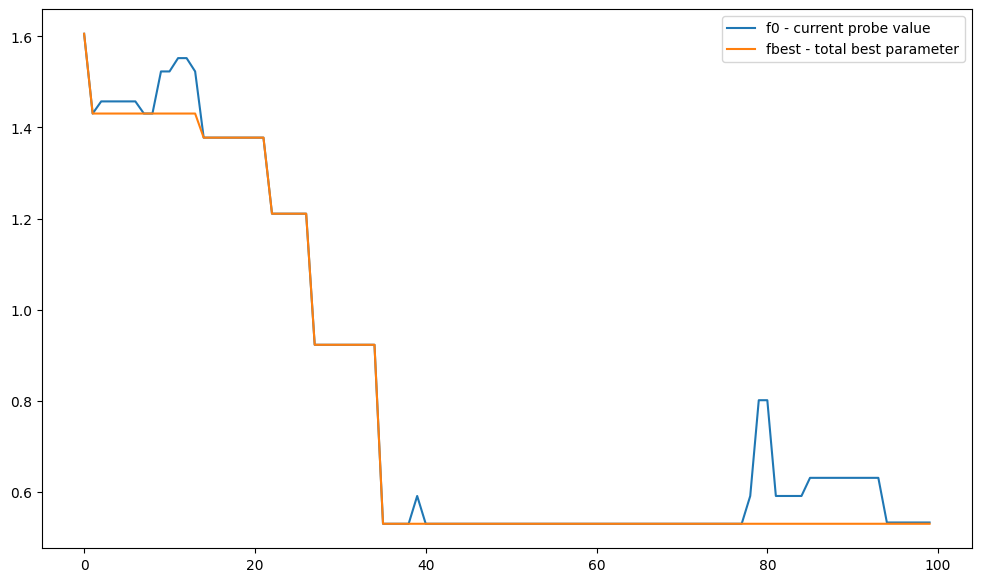

In [14]:
plt.figure(figsize = (12, 7))
plt.plot(optimization_progress['f0'], label = 'f0 - current probe value')
plt.plot(optimization_progress['fbest'], label = 'fbest - total best parameter')
plt.legend()
plt.show()

Select the best hyperparameters, refit to whole training set, and predict test set

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56527D+00    |proj g|=  5.71212D-01

At iterate    5    f=  1.51014D+00    |proj g|=  5.23791D-01

At iterate   10    f=  1.50949D+00    |proj g|=  6.44269D-01

At iterate   15    f=  1.49899D+00    |proj g|=  3.82920D+00

At iterate   20    f=  1.48107D+00    |proj g|=  1.05447D-01

At iterate   25    f=  1.47983D+00    |proj g|=  5.31564D-01

At iterate   30    f=  1.47943D+00    |proj g|=  2.24052D-02

At iterate   35    f=  1.47911D+00    |proj g|=  4.24958D-01

At iterate   40    f=  1.47479D+00    |proj g|=  6.88256D-02

At iterate   45    f=  1.47373D+00    |proj g|=  2.43949D-01

At iterate   50    f=  1.47173D+00    |proj g|=  4.67132D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

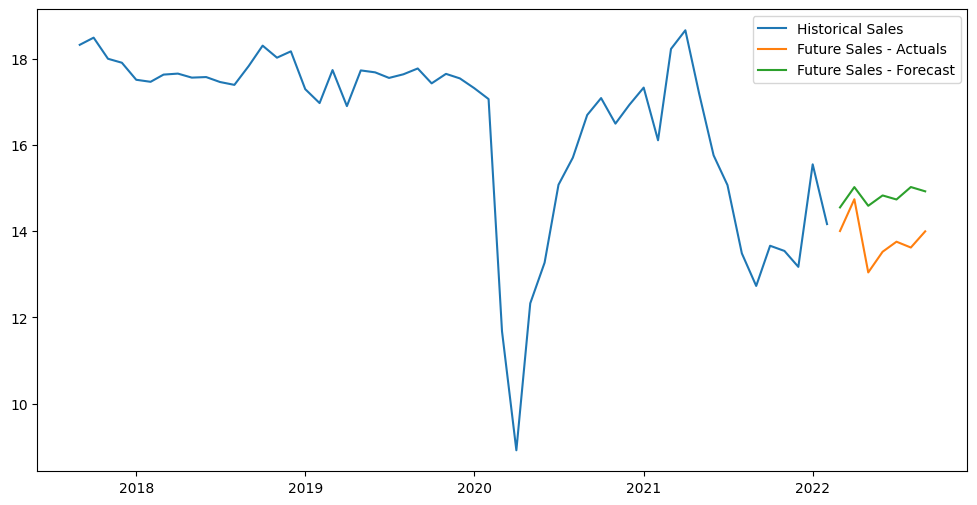

In [15]:
model = SARIMAX(
    endog = df_train['Sales'], 
    exog = df_train['GDP'], 
    order = (xbest['p'], xbest['d'], xbest['q']), # p, d, q order parameters for arima
    trend = [xbest['a0'], xbest['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (xbest['P'], xbest['D'], xbest['Q'], 12) # P, D, Q seasonal order parameters
).fit()

forecast = model.forecast(steps=df_test.shape[0], exog=df_test['GDP'])

plt.figure(figsize = (12, 6))
plt.plot(df_train['DATE'], df_train['Sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['Sales'], label='Future Sales - Actuals')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()